# 计算机网络体系结构第二次作业

作业要求：

> 1. 推导杜邦分析公式：ROE = 净利润率 x 总资产周转率 x 权益乘数，并简要分析宏观经济放缓对于 ROE 的影响。
> 2. 因为假的东西难以长久，看财报最好多看几年。1）利用 akshare 库获取上市公司的财务报表数据（代码参考附录 1），计算每只股票在 2021 年至 2023 年期间的 ROE（由于 akshare 没有给出归母净利润，这里假设净利润 = 归母净利润）。2）希望对同一板块的公司进行 ROE 的横向比较。
> 3. 在 2 的基础上，针对于 ROE 最高的公司，根据其某一年，如 2023 年的年度报表，进行杜邦分析。（markdown 画图可参考附录 2）

## 理论推导

### 杜邦分析公式

杜邦分析公式是一个用于分解公司 ROE 的公式，它将 ROE 分解为三个部分：净利润率、总资产周转率和权益乘数。具体推导如下：

$$
\begin{alignat*}{3}
    \text{净利润率}    & \coloneqq \frac{\text{归母净利润}}{\text{营业收入}} \tag{净利润率} \\
    \text{总资产周转率} & \coloneqq \frac{\text{营业收入}}{\text{平均总资产}} \tag{总资产周转率} \\
    \text{权益乘数}    & \coloneqq \frac{1}{1 - 资产负债率} \tag{权益乘数} \\
                      & = \frac{1}{1 - \frac{平均总负债}{平均总资产}} \\
                      & = \frac{平均总资产}{平均总资产 - 平均总负债} \\
                      & = \frac{\text{平均总资产}}{\text{净资产}} \\
    ROE               & \coloneqq \frac{\text{归母净利润}}{\text{净资产}} \tag{净资产收益率} \\
                      & = \frac{\text{归母净利润}}{\text{营业收入}} \times \frac{\text{营业收入}}{\text{净资产}} \\
                      & = \frac{\text{归母净利润}}{\text{营业收入}} \times \frac{\text{营业收入}}{\text{平均总资产}} \times \frac{\text{平均总资产}}{\text{净资产}} \\
                      & = \text{净利润率} \times \text{总资产周转率} \times \text{权益乘数}
\end{alignat*}
$$

## 实验设置

- 分析时间区间：2021 年至 2023 年。

### 杜邦分析设置

- 资产负债表
  - 总资产
    - 流动资产
      - 货币资金
      - 应收账款
      - 可供出售金融资产
    - 非流动资产
      - 固定资产
  - 总负债
    - 应付账款
    - 预收账款
    - 发放贷款及垫款
    - 向中央银行借款
    - 吸收存款
    - 卖出回购金融资产款
    - 结算备付金
    - 拆入资金
    - 代理买卖证券款
    - 应收保费
    - 短期借款
    - 预收保费
  - 所有者权益
    - 股东权益合计
- 利润表
  - 收入
    - 营业收入
    - 利息净收入
    - 手续费及佣金净收入
    - 已赚保费收入
    - 投资收入
  - 支出
    - 营业支出
    - 销售支出
    - 管理支出
    - 财务支出
    - 收入税支出
    - 营业税金及附加费支出
    - 退保金额支出
    - 赔付支出


## 实验原理、实现、结果与分析


由于 akshare 在处理数据时丢弃了一些列，我们对 akshare 1.13.16 的代码稍作更改。


In [205]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
"""
Date: 2022/5/1 19:48
Desc: 东方财富-数据中心-年报季报-业绩快报-三大报表
资产负债表
http://data.eastmoney.com/bbsj/202003/zcfz.html
利润表
http://data.eastmoney.com/bbsj/202003/lrb.html
现金流量表
http://data.eastmoney.com/bbsj/202003/xjll.html
"""
import pandas as pd
import requests
from tqdm import tqdm


def stock_zcfz_em(date: str = "20220331") -> pd.DataFrame:
    """
    东方财富-数据中心-年报季报-业绩快报-资产负债表
    http://data.eastmoney.com/bbsj/202003/zcfz.html
    :param date: choice of {"20200331", "20200630", "20200930", "20201231", "..."}; 从 20100331 开始
    :type date: str
    :return: 资产负债表
    :rtype: pandas.DataFrame
    """
    url = "https://datacenter-web.eastmoney.com/api/data/v1/get"
    params = {
        "sortColumns": "NOTICE_DATE,SECURITY_CODE",
        "sortTypes": "-1,-1",
        "pageSize": "500",
        "pageNumber": "1",
        "reportName": "RPT_DMSK_FN_BALANCE",
        "columns": "ALL",
        "filter": f"""(SECURITY_TYPE_CODE in ("058001001","058001008"))(TRADE_MARKET_CODE!="069001017")(REPORT_DATE='{'-'.join([date[:4], date[4:6], date[6:]])}')""",
    }
    r = requests.get(url, params=params)
    data_json = r.json()
    page_num = data_json["result"]["pages"]
    big_df = pd.DataFrame()
    for page in tqdm(range(1, page_num + 1), leave=False):
        params.update(
            {
                "pageNumber": page,
            }
        )
        r = requests.get(url, params=params)
        data_json = r.json()
        temp_df = pd.DataFrame(data_json["result"]["data"])
        big_df = pd.concat([big_df, temp_df], ignore_index=True)

    print(big_df.columns)
    big_df.reset_index(inplace=True)
    big_df["index"] = big_df.index + 1
    # 序号,	SECUCODE
    # _,	SECURITY_CODE
    # 股票代码,	INDUSTRY_CODE
    # _,	ORG_CODE
    # _,	SECURITY_NAME_ABBR
    # 股票简称,	INDUSTRY_NAME
    # _,	MARKET
    # _,	SECURITY_TYPE_CODE
    # _,	TRADE_MARKET_CODE
    # _,	DATE_TYPE_CODE
    # _,	REPORT_TYPE_CODE
    # _,	DATA_STATE
    # _,	NOTICE_DATE
    # 公告日期,	REPORT_DATE
    # _,	?
    # 资产-总资产,	TOTAL_ASSETS
    # 资产-固定资产,	FIXED_ASSET
    # 资产-货币资金,	MONETARYFUNDS
    # _,	MONETARYFUNDS_RATIO
    # 资产-应收账款,	ACCOUNTS_RECE
    # _,	ACCOUNTS_RECE_RATIO
    # 资产-存货,	INVENTORY
    # _,	INVENTORY_RATIO
    # 负债-总负债,	TOTAL_LIABILITIES
    # 负债-应付账款,	ACCOUNTS_PAYABLE
    # _,	ACCOUNTS_PAYABLE_RATIO
    # 负债-预收账款,	ADVANCE_RECEIVABLES
    # _,	ADVANCE_RECEIVABLES_RATIO
    # 股东权益合计,	TOTAL_EQUITY
    # _,	TOTAL_EQUITY_RATIO
    # 资产-总资产同比,	TOTAL_ASSETS_RATIO
    # 负债-总负债同比,	TOTAL_LIAB_RATIO
    # _,	CURRENT_RATIO
    # 资产负债率,	DEBT_ASSET_RATIO
    # 现金及存放中央银行款项,	CASH_DEPOSIT_PBC
    # _,	CDP_RATIO
    # 发放贷款及垫款,	LOAN_ADVANCE
    # _,	LOAN_ADVANCE_RATIO
    # 可供出售金融资产,	AVAILABLE_SALE_FINASSET
    # _,	ASF_RATIO
    # 向中央银行借款,	LOAN_PBC
    # _,	LOAN_PBC_RATIO
    # 吸收存款,	ACCEPT_DEPOSIT
    # _,	ACCEPT_DEPOSIT_RATIO
    # 卖出回购金融资产款,	SELL_REPO_FINASSET
    # _,	SRF_RATIO
    # 结算备付金,	SETTLE_EXCESS_RESERVE
    # _,	SER_RATIO
    # 拆入资金,	BORROW_FUND
    # _,	BORROW_FUND_RATIO
    # 代理买卖证券款,	AGENT_TRADE_SECURITY
    # _,	ATS_RATIO
    # 应收保费,	PREMIUM_RECE
    # _,	PREMIUM_RECE_RATIO
    # 短期借款,	SHORT_LOAN
    # _,	SHORT_LOAN_RATIO
    # 预收保费,	ADVANCE_PREMIUM
    # _,	ADVANCE_PREMIUM_RATIO
    columns = [
        "序号",
        "_",
        "股票代码",
        "_",
        "_",
        "股票简称",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "公告日期",
        "_",  # ?
        "资产-总资产",
        "资产-固定资产",
        "资产-货币资金",
        "_",
        "资产-应收账款",
        "_",
        "资产-存货",
        "_",
        "负债-总负债",
        "负债-应付账款",
        "_",
        "负债-预收账款",
        "_",
        "股东权益合计",
        "_",
        "资产-总资产同比",
        "负债-总负债同比",
        "_",
        "资产负债率",
        "现金及存放中央银行款项",
        "_",
        "发放贷款及垫款",
        "_",
        "可供出售金融资产",
        "_",
        "向中央银行借款",
        "_",
        "吸收存款",
        "_",
        "卖出回购金融资产款",
        "_",
        "结算备付金",
        "_",
        "拆入资金",
        "_",
        "代理买卖证券款",
        "_",
        "应收保费",
        "_",
        "短期借款",
        "_",
        "预收保费",
        "_",
    ]
    big_df.columns = columns
    big_df = big_df[
        [column for column in columns if column != "_"]
    ]

    big_df["公告日期"] = pd.to_datetime(big_df["公告日期"]).dt.date
    numeric_columns = [
        column for column in columns if column not in ["序号", "股票代码", "股票简称", "公告日期", "_"]
    ]
    for numeric_column in numeric_columns:
        big_df[numeric_column] = pd.to_numeric(big_df[numeric_column])

    # big_df["资产-货币资金"] = pd.to_numeric(big_df["资产-货币资金"])
    # big_df["资产-应收账款"] = pd.to_numeric(big_df["资产-应收账款"])
    # big_df["资产-存货"] = pd.to_numeric(big_df["资产-存货"])
    # big_df["资产-总资产"] = pd.to_numeric(big_df["资产-总资产"])
    # big_df["资产-总资产同比"] = pd.to_numeric(big_df["资产-总资产同比"])
    # big_df["负债-应付账款"] = pd.to_numeric(big_df["负债-应付账款"])
    # big_df["负债-预收账款"] = pd.to_numeric(big_df["负债-预收账款"])
    # big_df["负债-总负债"] = pd.to_numeric(big_df["负债-总负债"])
    # big_df["负债-总负债同比"] = pd.to_numeric(big_df["负债-总负债同比"])
    # big_df["资产负债率"] = pd.to_numeric(big_df["资产负债率"])
    # big_df["股东权益合计"] = pd.to_numeric(big_df["股东权益合计"])
    # big_df["股东权益合计"] = pd.to_numeric(big_df["股东权益合计"])
    return big_df


def stock_lrb_em(date: str = "20081231") -> pd.DataFrame:
    """
    东方财富-数据中心-年报季报-业绩快报-利润表
    https://data.eastmoney.com/bbsj/202003/lrb.html
    :param date: choice of {"20200331", "20200630", "20200930", "20201231", "..."}; 从 20100331 开始
    :type date: str
    :return: 利润表
    :rtype: pandas.DataFrame
    """
    url = "https://datacenter-web.eastmoney.com/api/data/v1/get"
    params = {
        "sortColumns": "NOTICE_DATE,SECURITY_CODE",
        "sortTypes": "-1,-1",
        "pageSize": "500",
        "pageNumber": "1",
        "reportName": "RPT_DMSK_FN_INCOME",
        "columns": "ALL",
        "filter": f"""(SECURITY_TYPE_CODE in ("058001001","058001008"))(TRADE_MARKET_CODE!="069001017")(REPORT_DATE='{'-'.join([date[:4], date[4:6], date[6:]])}')""",
    }
    r = requests.get(url, params=params)
    data_json = r.json()
    page_num = data_json["result"]["pages"]
    big_df = pd.DataFrame()
    for page in tqdm(range(1, page_num + 1), leave=False):
        params.update(
            {
                "pageNumber": page,
            }
        )
        r = requests.get(url, params=params)
        data_json = r.json()
        temp_df = pd.DataFrame(data_json["result"]["data"])
        big_df = pd.concat([big_df, temp_df], ignore_index=True)

    big_df.reset_index(inplace=True)
    big_df["index"] = big_df.index + 1
    # 序号,	index
    # _,	SECUCODE
    # 股票代码,	SECURITY_CODE
    # _,	INDUSTRY_CODE
    # _,	ORG_CODE
    # 股票简称,	SECURITY_NAME_ABBR
    # _,	INDUSTRY_NAME
    # _,	MARKET
    # _,	SECURITY_TYPE_CODE
    # _,	TRADE_MARKET_CODE
    # _,	DATE_TYPE_CODE
    # _,	REPORT_TYPE_CODE
    # _,	DATA_STATE
    # 公告日期,	NOTICE_DATE
    # _,	REPORT_DATE
    # 归母净利润,	PARENT_NETPROFIT
    # 营业总收入,	TOTAL_OPERATE_INCOME
    # 营业总支出-营业总支出,	TOTAL_OPERATE_COST
    # _,	TOE_RATIO
    # 营业总支出-营业支出,	OPERATE_COST
    # 营业总支出-营业费用,	OPERATE_EXPENSE
    # _,	OPERATE_EXPENSE_RATIO
    # 营业总支出-销售费用,	SALE_EXPENSE
    # 营业总支出-管理费用,	MANAGE_EXPENSE
    # 营业总支出-财务费用,	FINANCE_EXPENSE
    # 营业利润,	OPERATE_PROFIT
    # 利润总额,	TOTAL_PROFIT
    # 收入税,	INCOME_TAX
    # 营业收入,	OPERATE_INCOME
    # 利息净收入,	INTEREST_NI
    # _,	INTEREST_NI_RATIO
    # 手续费及佣金净收入,	FEE_COMMISSION_NI
    # _,	FCN_RATIO
    # 营业税金及附加,	OPERATE_TAX_ADD
    # _,	MANAGE_EXPENSE_BANK
    # _,	FCN_CALCULATE
    # _,	INTEREST_NI_CALCULATE
    # 已赚保费,	EARNED_PREMIUM
    # _,	EARNED_PREMIUM_RATIO
    # 投资收益,	INVEST_INCOME
    # 退保金额,	SURRENDER_VALUE
    # 赔付支出,	COMPENSATE_EXPENSE
    # 营业总收入同比,	TOI_RATIO
    # _,	OPERATE_PROFIT_RATIO
    # 归母净利润同比,	PARENT_NETPROFIT_RATIO
    # 扣减归母净利润,	DEDUCT_PARENT_NETPROFIT
    # _,	DPN_RATIO
    columns = [
        "序号",
        "_",
        "股票代码",
        "_",
        "_",
        "股票简称",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "公告日期",
        "_",
        "归母净利润",
        "营业总收入",
        "营业总支出-营业总支出",
        "_",
        "营业总支出-营业支出",
        "营业总支出-营业费用",
        "_",
        "营业总支出-销售费用",
        "营业总支出-管理费用",
        "营业总支出-财务费用",
        "营业利润",
        "利润总额",
        "收入税",
        "营业收入",
        "利息净收入",
        "_",
        "手续费及佣金净收入",
        "_",
        "营业税金及附加",
        "_",
        "_",
        "_",
        "已赚保费",
        "_",
        "投资收益",
        "退保金额",
        "赔付支出",
        "营业总收入同比",
        "_",
        "归母净利润同比",
        "扣减归母净利润",
        "_",
    ]
    big_df.columns = columns
    big_df = big_df[
        [column for column in columns if column != "_"]
    ]
    numeric_columns = [
        column for column in columns if column not in ["序号", "股票代码", "股票简称", "公告日期", "_"]
    ]

    big_df["公告日期"] = pd.to_datetime(big_df["公告日期"]).dt.date

    for numeric_column in numeric_columns:
        big_df[numeric_column] = pd.to_numeric(big_df[numeric_column])

    # big_df["净利润"] = pd.to_numeric(big_df["净利润"])
    # big_df["净利润同比"] = pd.to_numeric(big_df["净利润同比"])
    # big_df["营业总收入"] = pd.to_numeric(big_df["营业总收入"])
    # big_df["营业总收入同比"] = pd.to_numeric(big_df["营业总收入同比"])
    # big_df["营业总支出-营业支出"] = pd.to_numeric(big_df["营业总支出-营业支出"])
    # big_df["营业总支出-销售费用"] = pd.to_numeric(big_df["营业总支出-销售费用"])
    # big_df["营业总支出-管理费用"] = pd.to_numeric(big_df["营业总支出-管理费用"])
    # big_df["营业总支出-财务费用"] = pd.to_numeric(big_df["营业总支出-财务费用"])
    # big_df["营业总支出-营业总支出"] = pd.to_numeric(big_df["营业总支出-营业总支出"])
    # big_df["营业利润"] = pd.to_numeric(big_df["营业利润"])
    # big_df["利润总额"] = pd.to_numeric(big_df["利润总额"])

    return big_df


def stock_xjll_em(date: str = "20220331") -> pd.DataFrame:
    """
    东方财富-数据中心-年报季报-业绩快报-现金流量表
    http://data.eastmoney.com/bbsj/202003/xjll.html
    :param date: choice of {"20200331", "20200630", "20200930", "20201231", "..."}; 从 20100331 开始
    :type date: str
    :return: 现金流量表
    :rtype: pandas.DataFrame
    """
    url = "https://datacenter-web.eastmoney.com/api/data/v1/get"
    params = {
        "sortColumns": "NOTICE_DATE,SECURITY_CODE",
        "sortTypes": "-1,-1",
        "pageSize": "500",
        "pageNumber": "1",
        "reportName": "RPT_DMSK_FN_CASHFLOW",
        "columns": "ALL",
        "filter": f"""(SECURITY_TYPE_CODE in ("058001001","058001008"))(TRADE_MARKET_CODE!="069001017")(REPORT_DATE='{'-'.join([date[:4], date[4:6], date[6:]])}')""",
    }
    r = requests.get(url, params=params)
    data_json = r.json()
    page_num = data_json["result"]["pages"]
    big_df = pd.DataFrame()
    for page in tqdm(range(1, page_num + 1), leave=False):
        params.update(
            {
                "pageNumber": page,
            }
        )
        r = requests.get(url, params=params)
        data_json = r.json()
        temp_df = pd.DataFrame(data_json["result"]["data"])
        big_df = pd.concat([big_df, temp_df], ignore_index=True)

    big_df.reset_index(inplace=True)
    big_df["index"] = big_df.index + 1
    # 序号,	index
    # _,	SECUCODE
    # 股票代码,	SECURITY_CODE
    # _,	INDUSTRY_CODE
    # _,	ORG_CODE
    # 股票简称,	SECURITY_NAME_ABBR
    # _,	INDUSTRY_NAME
    # _,	MARKET
    # _,	SECURITY_TYPE_CODE
    # _,	TRADE_MARKET_CODE
    # _,	DATE_TYPE_CODE
    # _,	REPORT_TYPE_CODE
    # _,	DATA_STATE
    # 公告日期,	NOTICE_DATE
    # _,	REPORT_DATE
    # 经营性现金流-现金流量净额,	NETCASH_OPERATE
    # 经营性现金流-净现金流占比,	NETCASH_OPERATE_RATIO
    # _,	SALES_SERVICES
    # _,	SALES_SERVICES_RATIO
    # _,	PAY_STAFF_CASH
    # _,	PSC_RATIO
    # 投资性现金流-现金流量净额,	NETCASH_INVEST
    # 投资性现金流-净现金流占比,	NETCASH_INVEST_RATIO
    # _,	RECEIVE_INVEST_INCOME
    # _,	RII_RATIO
    # _,	CONSTRUCT_LONG_ASSET
    # _,	CLA_RATIO
    # 融资性现金流-现金流量净额,	NETCASH_FINANCE
    # 融资性现金流-净现金流占比,	NETCASH_FINANCE_RATIO
    # 净现金流-净现金流,	CCE_ADD
    # 净现金流-同比增长,	CCE_ADD_RATIO
    # _,	CUSTOMER_DEPOSIT_ADD
    # _,	CDA_RATIO
    # _,	DEPOSIT_IOFI_OTHER
    # _,	DIO_RATIO
    # _,	LOAN_ADVANCE_ADD
    # _,	LAA_RATIO
    # _,	RECEIVE_INTEREST_COMMISSION
    # _,	RIC_RATIO
    # _,	INVEST_PAY_CASH
    # _,	IPC_RATIO
    # _,	BEGIN_CCE
    # _,	BEGIN_CCE_RATIO
    # _,	END_CCE
    # _,	END_CCE_RATIO
    # _,	RECEIVE_ORIGIC_PREMIUM
    # _,	ROP_RATIO
    # _,	PAY_ORIGIC_COMPENSATE
    # _,	POC_RATIO
    columns = [
        "序号",
        "_",
        "股票代码",
        "_",
        "_",
        "股票简称",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "公告日期",
        "_",
        "经营性现金流-现金流量净额",
        "经营性现金流-净现金流占比",
        "_",
        "_",
        "_",
        "_",
        "投资性现金流-现金流量净额",
        "投资性现金流-净现金流占比",
        "_",
        "_",
        "_",
        "_",
        "融资性现金流-现金流量净额",
        "融资性现金流-净现金流占比",
        "净现金流-净现金流",
        "净现金流-同比增长",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
    ]
    big_df.columns = columns
    big_df = big_df[
        [column for column in columns if column != "_"]
    ]

    big_df["公告日期"] = pd.to_datetime(big_df["公告日期"]).dt.date

    numeric_columns = [
        column for column in columns if column not in ["序号", "股票代码", "股票简称", "公告日期", "_"]
    ]
    for numeric_column in numeric_columns:
        big_df[numeric_column] = pd.to_numeric(big_df[numeric_column])

    # big_df["净现金流-净现金流"] = pd.to_numeric(big_df["净现金流-净现金流"])
    # big_df["净现金流-同比增长"] = pd.to_numeric(big_df["净现金流-同比增长"])
    # big_df["经营性现金流-现金流量净额"] = pd.to_numeric(big_df["经营性现金流-现金流量净额"])
    # big_df["经营性现金流-净现金流占比"] = pd.to_numeric(big_df["经营性现金流-净现金流占比"])
    # big_df["投资性现金流-现金流量净额"] = pd.to_numeric(big_df["投资性现金流-现金流量净额"])
    # big_df["投资性现金流-净现金流占比"] = pd.to_numeric(big_df["投资性现金流-净现金流占比"])
    # big_df["融资性现金流-现金流量净额"] = pd.to_numeric(big_df["融资性现金流-现金流量净额"])
    # big_df["融资性现金流-净现金流占比"] = pd.to_numeric(big_df["融资性现金流-净现金流占比"])

    return big_df


#!/usr/bin/env python
# -*- coding:utf-8 -*-
"""
Date: 2022/11/12 21:27
Desc: 东方财富-数据中心-年报季报
东方财富-数据中心-年报季报-业绩快报-业绩报表
https://data.eastmoney.com/bbsj/202003/yjbb.html
"""
# import pandas as pd
# import requests
# from tqdm import tqdm


def stock_yjbb_em(date: str = "20200331") -> pd.DataFrame:
    """
    东方财富-数据中心-年报季报-业绩快报-业绩报表
    https://data.eastmoney.com/bbsj/202003/yjbb.html
    :param date: "20200331", "20200630", "20200930", "20201231"; 从 20100331 开始
    :type date: str
    :return: 业绩报表
    :rtype: pandas.DataFrame
    """
    url = "https://datacenter-web.eastmoney.com/api/data/v1/get"
    params = {
        'sortColumns': 'UPDATE_DATE,SECURITY_CODE',
        'sortTypes': '-1,-1',
        'pageSize': '500',
        'pageNumber': '1',
        'reportName': 'RPT_LICO_FN_CPD',
        'columns': 'ALL',
        'filter': f"(REPORTDATE='{'-'.join([date[:4], date[4:6], date[6:]])}')",
    }
    r = requests.get(url, params=params)
    data_json = r.json()
    page_num = data_json["result"]["pages"]
    big_df = pd.DataFrame()
    for page in tqdm(range(1, page_num + 1), leave=False):
        params.update({
            'pageNumber': page,
        })
        r = requests.get(url, params=params)
        data_json = r.json()
        temp_df = pd.DataFrame(data_json["result"]["data"])
        big_df = pd.concat([big_df, temp_df], ignore_index=True)

    big_df.reset_index(inplace=True)
    big_df["index"] = range(1, len(big_df) + 1)
    print(big_df.columns)
    big_df.to_excel("yjbb.xlsx", index=False)
    # 序号,	index
    # 股票代码,	SECURITY_CODE
    # 股票简称,	SECURITY_NAME_ABBR
    # _,	TRADE_MARKET_CODE
    # _,	TRADE_MARKET
    # _,	SECURITY_TYPE_CODE
    # _,	SECURITY_TYPE
    # 最新公告日期,	UPDATE_DATE
    # _,	REPORTDATE
    # 每股收益,	BASIC_EPS
    # _,	DEDUCT_BASIC_EPS
    # 营业收入-营业收入,	TOTAL_OPERATE_INCOME
    # 净利润-净利润,	PARENT_NETPROFIT
    # 净资产收益率,	WEIGHTAVG_ROE
    # 营业收入-同比增长,	YSTZ
    # 净利润-同比增长,	SJLTZ
    # 每股净资产,	BPS
    # 每股经营现金流量,	MGJYXJJE
    # 销售毛利率,	XSMLL
    # 营业收入-季度环比增长,	YSHZ
    # 净利润-季度环比增长,	SJLHZ
    # _,	ASSIGNDSCRPT
    # _,	PAYYEAR
    # 所处行业,	PUBLISHNAME
    # _,	ZXGXL
    # _,	NOTICE_DATE
    # _,	ORG_CODE
    # _,	TRADE_MARKET_ZJG
    # _,	ISNEW
    # _,	QDATE
    # _,	DATATYPE
    # _,	DATAYEAR
    # _,	DATEMMDD
    # _,	EITIME
    # _,	SECUCODE
    columns = [
        "序号",
        "股票代码",
        "股票简称",
        "_",
        "_",
        "_",
        "_",
        "最新公告日期",
        "_",
        "每股收益",
        "_",
        "营业收入-营业收入",
        "净利润-净利润",
        "净资产收益率",
        "营业收入-同比增长",
        "净利润-同比增长",
        "每股净资产",
        "每股经营现金流量",
        "销售毛利率",
        "营业收入-季度环比增长",
        "净利润-季度环比增长",
        "_",
        "_",
        "所处行业",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
        "_",
    ]
    big_df.columns = columns
    big_df = big_df[
        [column for column in columns if column != "_"]
    ]

    big_df['最新公告日期'] = pd.to_datetime(big_df['最新公告日期']).dt.date

    numeric_columns = [
        column for column in columns if column not in ["序号", "股票代码", "股票简称", "最新公告日期", "所处行业", "_"]
    ]
    for numeric_column in numeric_columns:
        big_df[numeric_column] = pd.to_numeric(big_df[numeric_column])

    # big_df['每股收益'] = pd.to_numeric(big_df['每股收益'], errors="coerce")
    # big_df['营业收入-营业收入'] = pd.to_numeric(big_df['营业收入-营业收入'], errors="coerce")
    # big_df['营业收入-同比增长'] = pd.to_numeric(big_df['营业收入-同比增长'], errors="coerce")
    # big_df['营业收入-季度环比增长'] = pd.to_numeric(
    #     big_df['营业收入-季度环比增长'], errors="coerce")
    # big_df['净利润-净利润'] = pd.to_numeric(big_df['净利润-净利润'], errors="coerce")
    # big_df['净利润-同比增长'] = pd.to_numeric(big_df['净利润-同比增长'], errors="coerce")
    # big_df['净利润-季度环比增长'] = pd.to_numeric(big_df['净利润-季度环比增长'], errors="coerce")
    # big_df['每股净资产'] = pd.to_numeric(big_df['每股净资产'], errors="coerce")
    # big_df['净资产收益率'] = pd.to_numeric(big_df['净资产收益率'], errors="coerce")
    # big_df['每股经营现金流量'] = pd.to_numeric(big_df['每股经营现金流量'], errors="coerce")
    # big_df['销售毛利率'] = pd.to_numeric(big_df['销售毛利率'], errors="coerce")
    return big_df

### 数据准备


In [206]:
from typing import Callable
from pylab import mpl
from matplotlib import pyplot as plt
import os
import os.path as path
import pandas as pd
import pathlib as pl
import akshare as ak


# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["Songti SC"]
mpl.rcParams["axes.unicode_minus"] = False


class DataLoader:
    """
    Load data from akshare and save it to local file.
    """
    stock_zcfz_em_df: pd.DataFrame
    stock_lrb_em_df: pd.DataFrame
    stock_xjll_em_df: pd.DataFrame
    stock_yjbb_em_df: pd.DataFrame

    def __init__(self, date: str):
        self.load_data(date)

    @staticmethod
    def load_df_em(p: pl.Path, getter: Callable[[], pd.DataFrame]) -> pd.DataFrame:
        '''
        Load DataFrame from local file, if the file does not exist, call getter to get the data.
        '''
        # 使用 pickle 格式保存数据以保证类型的准确和减少加载时间
        if not path.exists(p):
            df = getter()
            df.set_index("股票代码", inplace=True)
            df.to_pickle(p)
        return pd.read_pickle(p)

    @staticmethod
    def load_df_sina(p: pl.Path, getter: Callable[[], pd.DataFrame]) -> tuple[pd.DataFrame, bool]:
        '''
        Load DataFrame from local file, if the file does not exist, call getter to get the data.
        '''
        # 使用 pickle 格式保存数据以保证类型的准确和减少加载时间
        cached = True
        if not path.exists(p):
            df = getter()
            df.to_pickle(p)
            cached = False
        return pd.read_pickle(p), cached

    def load_data(self, date: str):
        DIR = pl.Path("data")
        os.makedirs(DIR, exist_ok=True)
        self.stock_zcfz_em_df = self.load_df_em(
            DIR / f"stock_zcfz_em-{date}.pkl",
            lambda: stock_zcfz_em(date=date)
        )
        self.stock_lrb_em_df = self.load_df_em(
            DIR / f"stock_lrb_em-{date}.pkl",
            lambda: stock_lrb_em(date=date)
        )
        self.stock_xjll_em_df = self.load_df_em(
            DIR / f"stock_xjll_em-{date}.pkl",
            lambda: stock_xjll_em(date=date)
        )
        self.stock_yjbb_em_df = self.load_df_em(
            DIR / f"stock_yjbb_em-{date}.pkl",
            lambda: stock_yjbb_em(date=date)
        )

- 读取财务数据，并查看可用的信息。


In [207]:
DATES = ["20201231", "20211231", "20221231", "20231231"]
data = {date: DataLoader(date) for date in DATES}


def show_columns():
    start = data["20201231"]
    print(start.stock_zcfz_em_df.columns)
    print(start.stock_lrb_em_df.columns)
    print(start.stock_xjll_em_df.columns)
    print(start.stock_yjbb_em_df.columns)


show_columns()

Index(['序号', '股票简称', '公告日期', '资产-总资产', '资产-固定资产', '资产-货币资金', '资产-应收账款',
       '资产-存货', '负债-总负债', '负债-应付账款', '负债-预收账款', '股东权益合计', '资产-总资产同比',
       '负债-总负债同比', '资产负债率', '现金及存放中央银行款项', '发放贷款及垫款', '可供出售金融资产', '向中央银行借款',
       '吸收存款', '卖出回购金融资产款', '结算备付金', '拆入资金', '代理买卖证券款', '应收保费', '短期借款',
       '预收保费'],
      dtype='object')
Index(['序号', '股票简称', '公告日期', '归母净利润', '营业总收入', '营业总支出-营业总支出', '营业总支出-营业支出',
       '营业总支出-营业费用', '营业总支出-销售费用', '营业总支出-管理费用', '营业总支出-财务费用', '营业利润', '利润总额',
       '收入税', '营业收入', '利息净收入', '手续费及佣金净收入', '营业税金及附加', '已赚保费', '投资收益', '退保金额',
       '赔付支出', '营业总收入同比', '归母净利润同比', '扣减归母净利润'],
      dtype='object')
Index(['序号', '股票简称', '公告日期', '经营性现金流-现金流量净额', '经营性现金流-净现金流占比', '投资性现金流-现金流量净额',
       '投资性现金流-净现金流占比', '融资性现金流-现金流量净额', '融资性现金流-净现金流占比', '净现金流-净现金流',
       '净现金流-同比增长'],
      dtype='object')
Index(['序号', '股票简称', '最新公告日期', '每股收益', '营业收入-营业收入', '净利润-净利润', '净资产收益率',
       '营业收入-同比增长', '净利润-同比增长', '每股净资产', '每股经营现金流量', '销售毛利率', '营业收入-季度环比增长',
       '净利润-季度环比增长', '

- 查看资产负债率概况。


In [208]:
print(pd.DataFrame.from_dict({
    date: data[date].stock_zcfz_em_df.资产负债率.describe() for date in DATES
}))

           20201231     20211231     20221231     20231231
count   5170.000000  5166.000000  5131.000000  2903.000000
mean      45.782102    42.627895    42.254820    40.421623
std      248.432711    21.657821    22.613028    21.272054
min        1.306203     1.495593     1.557874     2.107879
25%       25.746219    25.782649    24.701444    23.201114
50%       40.902024    41.091894    40.611636    39.250374
75%       56.628315    56.864707    57.016438    55.440900
max    17834.547318   159.237049   244.153123   122.284584


- 查看年度净利润概况。


In [209]:
print(pd.DataFrame.from_dict({
    date: data[date].stock_lrb_em_df['归母净利润'].describe() for date in DATES
}))

           20201231      20211231      20221231      20231231
count  5.170000e+03  5.166000e+03  5.158000e+03  2.903000e+03
mean   8.395560e+08  1.000283e+09  1.026994e+09  1.560499e+09
std    8.313098e+09  9.345872e+09  1.024536e+10  1.335970e+10
min   -6.400331e+10 -4.326461e+10 -3.861950e+10 -8.168000e+09
25%    4.776486e+07  4.684590e+07  2.198180e+07  3.918092e+07
50%    1.116375e+08  1.242840e+08  1.116421e+08  1.396576e+08
75%    3.285773e+08  3.887146e+08  3.682492e+08  4.614542e+08
max    3.159060e+11  3.483380e+11  3.611320e+11  3.639930e+11


- 收集在 2021 年到 2023 年都处于上市状态且发布了年度财报的股票。


In [210]:
codes: set = set(data[DATES[0]].stock_zcfz_em_df.index.array)
for date in DATES[1:]:
    codes = codes.intersection(set(data[date].stock_zcfz_em_df.index.array))
list_codes: list = [*codes]
list_codes.sort()
print(len(list_codes))

2903


In [211]:
from random import random
from time import sleep
from tqdm import tqdm


class FinancialLoader:
    stock_financial_analysis_indicator_df: dict[str, pd.DataFrame]

    def __init__(self, codes: list[str], names: dict[str, str]):
        DIR = pl.Path("data")
        self.stock_financial_analysis_indicator_df = dict()
        for code in tqdm(codes):
            os.makedirs(DIR / "stocks" / code, exist_ok=True)
            self.stock_financial_analysis_indicator_df[code], cached = DataLoader.load_df_sina(
                DIR / "stocks" / code / f"stock_financial_analysis_indicator.pkl",
                lambda: ak.stock_financial_analysis_indicator(
                    symbol=code)
            )
            if not cached:
                sleep(28+4*random())


# financial = FinancialLoader(list_codes, {
#                             code: data[DATES[0]].stock_zcfz_em_df.loc[code, "股票简称"] for code in list_codes})

### 计算指标


In [212]:
def period(DATE: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    assert len(DATE) > 1
    # 计算期间的归母净利润、营业总收入、总成本等指标的总和。
    parent_net_profits = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, "归母净利润"]
        for date in DATE[1:]
    }).sum(axis=1)
    total_operate_incomes = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, "营业总收入"]
        for date in DATE[1:]
    }).sum(axis=1)
    total_operate_costs = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '营业总支出-营业总支出']
        for date in DATE[1:]
    }).sum(axis=1)
    operating_expenses = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '营业总支出-营业支出']
        for date in DATE[1:]
    }).sum(axis=1)
    sales_expenses = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '营业总支出-销售费用']
        for date in DATE[1:]
    }).sum(axis=1)
    manage_expenses = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '营业总支出-管理费用']
        for date in DATE[1:]
    }).sum(axis=1)
    financial_expenses = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '营业总支出-财务费用']
        for date in DATE[1:]
    }).sum(axis=1)
    income_taxes = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '收入税']
        for date in DATE[1:]
    }).sum(axis=1)
    operate_incomes = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '营业收入']
        for date in DATE[1:]
    }).sum(axis=1)
    interest_net_incomes = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '利息净收入']
        for date in DATE[1:]
    }).sum(axis=1)
    fee_commission_net_incomes = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '手续费及佣金净收入']
        for date in DATE[1:]
    }).sum(axis=1)
    operate_tax_adds = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '营业税金及附加']
        for date in DATE[1:]
    }).sum(axis=1)
    earned_premiums = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '已赚保费']
        for date in DATE[1:]
    }).sum(axis=1)
    invest_incomes = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '投资收益']
        for date in DATE[1:]
    }).sum(axis=1)
    surrender_values = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '退保金额']
        for date in DATE[1:]
    }).sum(axis=1)
    compensate_values = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '赔付支出']
        for date in DATE[1:]
    }).sum(axis=1)
    deduct_parent_net_profits = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '扣减归母净利润']
        for date in DATE[1:]
    }).sum(axis=1)

    # 计算如下指标：净利润率、总资产周转率、权益乘数和 ROE。

    result = pd.DataFrame({
        '股票代码': list_codes,
        '股票简称': data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '股票简称'],
        '归母净利润':  parent_net_profits,
        '扣减归母净利润':  deduct_parent_net_profits,
        '营业总收入': total_operate_incomes,
        "营业收入": operate_incomes,
        "利息净收入": interest_net_incomes,
        "手续费及佣金净收入": fee_commission_net_incomes,
        "已赚保费收入": earned_premiums,
        "投资收入": invest_incomes,
        "营业总支出": total_operate_costs,
        "营业支出": operating_expenses,
        "销售支出": sales_expenses,
        "管理支出": manage_expenses,
        "财务支出": financial_expenses,
        "收入税支出": income_taxes,
        "营业税金及附加费支出": operate_tax_adds,
        "退保金额支出": surrender_values,
        '赔付支出': compensate_values,
        '平均总资产': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '资产-总资产'] +
                  data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '资产-总资产']) / 2,
        '平均固定资产': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '资产-固定资产'] +
                   data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '资产-固定资产']) / 2,
        '平均货币资金': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '资产-货币资金'] +
                   data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '资产-货币资金']) / 2,
        '平均应收账款': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '资产-应收账款'] +
                   data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '资产-应收账款']) / 2,
        '平均总负债': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '负债-总负债'] +
                  data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '负债-总负债']) / 2,
        '平均应付账款': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '负债-应付账款'] +
                   data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '负债-应付账款']) / 2,
        '平均预收账款': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '负债-预收账款'] +
                   data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '负债-预收账款']) / 2,
        '平均股东权益合计': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '股东权益合计'] +
                     data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '股东权益合计']) / 2,
        '平均发放贷款及垫款': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '发放贷款及垫款'] +
                      data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '发放贷款及垫款']) / 2,
        '平均可供出售金融资产': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '可供出售金融资产'] +
                       data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '可供出售金融资产']) / 2,
        '平均向中央银行借款': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '向中央银行借款'] +
                      data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '向中央银行借款']) / 2,
        '平均吸收存款': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '吸收存款'] +
                   data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '吸收存款']) / 2,
        '平均卖出回购金融资产款': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '卖出回购金融资产款'] +
                        data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '卖出回购金融资产款']) / 2,
        '平均结算备付金': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '结算备付金'] +
                    data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '结算备付金']) / 2,
        '平均拆入资金': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '拆入资金'] +
                   data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '拆入资金']) / 2,
        '平均代理买卖证券款': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '代理买卖证券款'] +
                      data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '代理买卖证券款']) / 2,
        '平均应收保费': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '应收保费'] +
                   data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '应收保费']) / 2,
        '平均短期借款': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '短期借款'] +
                   data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '短期借款']) / 2,
        '平均预收保费': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '预收保费'] +
                   data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '预收保费']) / 2,
    })
    result.set_index('股票代码', inplace=True)
    result['营业净利润率'] = result['归母净利润'] / result['营业总收入']
    result['总资产周转率'] = result['营业总收入'] / result['平均总资产']
    result['资产负债率'] = result['平均总负债'] / result['平均总资产']
    result['净资产'] = result['平均总资产'] - result['平均总负债']
    result['权益乘数'] = result['平均总资产'] / result['净资产']
    result['净资产收益率'] = result['归母净利润'] / result['净资产']

    # 去除净资产为负的股票。
    print(result[result.loc[:, '净资产'] <= 0])
    result = result[result.loc[:, '净资产'] > 0]

    # 去除营业收入为负的股票。
    print(result[result.loc[:, '营业总收入'] <= 0])
    result = result[result.loc[:, '营业总收入'] > 0]

    # 去除归母净利润为负的股票。（可选）
    # print(result[result.loc[:, '归母净利润'] <= 0])
    # result = result[result.loc[:, '归母净利润'] > 0]

    description = pd.DataFrame.from_dict({
        "净利润": parent_net_profits.describe(),
        "营业总收入": total_operate_incomes.describe(),
        "营业总支出": total_operate_costs.describe(),
        "营业支出": operating_expenses.describe(),
        "销售支出": sales_expenses.describe(),
        "管理支出": manage_expenses.describe(),
        "财务支出": financial_expenses.describe(),
    })
    return (result, description)

#### 计算每年指标


In [213]:
results_year_wise: list[pd.DataFrame] = []

In [214]:
result, description = period(DATES[0:2])
results_year_wise.append(result)

        股票简称         归母净利润       扣减归母净利润         营业总收入  营业收入  利息净收入  \
股票代码                                                                  
000523  红棉股份  1.455423e+09 -1.899450e+08  2.585546e+09   0.0    0.0   
002356  赫美集团  8.998505e+08 -3.513639e+08  3.327944e+08   0.0    0.0   
002766  索菱股份 -6.702076e+08 -1.632614e+09  7.619576e+08   0.0    0.0   
300071  福石控股  2.295238e+08 -1.066105e+08  1.035383e+09   0.0    0.0   
600518  ST康美  7.917901e+09 -7.968233e+09  4.152521e+09   0.0    0.0   
600734  ST实达  6.899309e+08 -1.716028e+09  9.218199e+08   0.0    0.0   
688520  神州细胞 -8.668506e+08 -8.862099e+08  1.343928e+08   0.0    0.0   

        手续费及佣金净收入  已赚保费收入  投资收入         营业总支出  ...  平均代理买卖证券款  平均应收保费  平均短期借款  \
股票代码                                           ...                              
000523        0.0     0.0   0.0  2.832365e+09  ...        NaN     NaN     NaN   
002356        0.0     0.0   0.0  5.763247e+08  ...        NaN     NaN     NaN   
002766        0.0     0.0   0.0  1.6

In [215]:
description.style.format("{:.3e}")

,净利润,营业总收入,营业总支出,营业支出,销售支出,管理支出,财务支出
count,2.903e+03,2.903e+03,2.903e+03,2.903e+03,2.903e+03,2.903e+03,2.903e+03
mean,1.513e+09,1.748e+10,1.554e+10,1.167e+10,4.278e+08,1.065e+09,1.286e+08
std,1.226e+10,1.037e+11,9.491e+10,7.862e+10,2.625e+09,9.398e+09,6.966e+08
min,-4.326e+10,0.000e+00,2.505e+07,0.000e+00,0.000e+00,0.000e+00,-8.096e+09
25%,6.227e+07,8.077e+08,7.055e+08,4.475e+08,1.866e+07,5.141e+07,-1.534e+06
50%,1.506e+08,2.007e+09,1.769e+09,1.222e+09,5.453e+07,1.113e+08,7.131e+06
75%,4.790e+08,6.041e+09,5.450e+09,3.917e+09,1.895e+08,2.803e+08,4.745e+07
max,3.483e+11,2.741e+12,2.629e+12,2.217e+12,7.130e+10,2.259e+11,1.704e+10


In [216]:
result, description = period(DATES[1:3])
results_year_wise.append(result)

        股票简称         归母净利润       扣减归母净利润         营业总收入  营业收入  利息净收入  \
股票代码                                                                  
000523  红棉股份 -4.815630e+07 -7.276436e+07  2.636882e+09   0.0    0.0   
002356  赫美集团 -6.168126e+07 -8.980538e+07  1.623715e+08   0.0    0.0   
002766  索菱股份  8.795660e+06  1.016518e+06  8.281859e+08   0.0    0.0   
300071  福石控股  2.922470e+07 -1.531289e+07  1.213967e+09   0.0    0.0   
600518  ST康美 -2.688159e+09 -1.508035e+09  4.180150e+09   0.0    0.0   
600734  ST实达 -9.758113e+07 -1.369924e+08  2.623149e+08   0.0    0.0   
688520  神州细胞 -5.189958e+08 -3.956766e+08  1.023177e+09   0.0    0.0   

        手续费及佣金净收入  已赚保费收入  投资收入         营业总支出  ...  平均代理买卖证券款  平均应收保费  平均短期借款  \
股票代码                                           ...                              
000523        0.0     0.0   0.0  2.695315e+09  ...        NaN     NaN     NaN   
002356        0.0     0.0   0.0  1.858164e+08  ...        NaN     NaN     NaN   
002766        0.0     0.0   0.0  8.2

In [217]:
description.style.format("{:.3e}")

,净利润,营业总收入,营业总支出,营业支出,销售支出,管理支出,财务支出
count,2.903e+03,2.903e+03,2.903e+03,2.903e+03,2.903e+03,2.903e+03,2.903e+03
mean,1.586e+09,1.866e+10,1.662e+10,1.297e+10,4.421e+08,1.095e+09,1.112e+08
std,1.344e+10,1.166e+11,1.075e+11,9.244e+10,2.654e+09,9.658e+09,8.357e+08
min,-3.862e+10,2.610e+04,3.231e+07,0.000e+00,0.000e+00,0.000e+00,-8.605e+09
25%,4.489e+07,8.344e+08,7.599e+08,4.782e+08,1.908e+07,5.618e+07,-1.294e+07
50%,1.415e+08,2.073e+09,1.885e+09,1.336e+09,5.762e+07,1.192e+08,0.000e+00
75%,4.500e+08,6.537e+09,5.789e+09,4.350e+09,1.953e+08,2.935e+08,3.341e+07
max,3.611e+11,3.318e+12,3.232e+12,2.819e+12,6.835e+10,2.281e+11,1.967e+10


In [218]:
result, description = period(DATES[2:4])
results_year_wise.append(result)

        股票简称         归母净利润       扣减归母净利润         营业总收入  营业收入  利息净收入  \
股票代码                                                                  
000523  红棉股份  7.483287e+07  4.165054e+07  2.629216e+09   0.0    0.0   
002356  赫美集团 -4.720349e+07 -2.814256e+07  1.649858e+08   0.0    0.0   
002766  索菱股份  3.259981e+07  3.350717e+07  1.259882e+09   0.0    0.0   
300071  福石控股 -2.145291e+07 -3.509662e+07  1.379722e+09   0.0    0.0   
600518  ST康美  1.025212e+08 -7.528586e+08  4.874016e+09   0.0    0.0   
600734  ST实达  3.719580e+07  2.914461e+07  3.354795e+08   0.0    0.0   
688520  神州细胞 -3.960183e+08 -6.368049e+07  1.887349e+09   0.0    0.0   

        手续费及佣金净收入  已赚保费收入  投资收入         营业总支出  ...  平均代理买卖证券款  平均应收保费  平均短期借款  \
股票代码                                           ...                              
000523        0.0     0.0   0.0  2.559470e+09  ...        NaN     NaN     NaN   
002356        0.0     0.0   0.0  1.854632e+08  ...        NaN     NaN     NaN   
002766        0.0     0.0   0.0  1.2

In [219]:
description.style.format("{:.3e}")

,净利润,营业总收入,营业总支出,营业支出,销售支出,管理支出,财务支出
count,2.903e+03,2.903e+03,2.903e+03,2.903e+03,2.903e+03,2.903e+03,2.903e+03
mean,1.560e+09,1.889e+10,1.695e+10,1.316e+10,4.804e+08,1.132e+09,1.117e+08
std,1.336e+10,1.158e+11,1.072e+11,9.151e+10,2.831e+09,9.898e+09,7.748e+08
min,-8.168e+09,0.000e+00,3.170e+07,0.000e+00,0.000e+00,0.000e+00,-5.657e+09
25%,3.918e+07,8.883e+08,7.999e+08,4.932e+08,2.228e+07,6.136e+07,-1.045e+07
50%,1.397e+08,2.137e+09,1.965e+09,1.379e+09,6.368e+07,1.265e+08,6.804e+05
75%,4.615e+08,6.613e+09,5.975e+09,4.367e+09,2.112e+08,3.110e+08,3.662e+07
max,3.640e+11,3.212e+12,3.138e+12,2.710e+12,7.026e+10,2.353e+11,1.858e+10


In [220]:
# results = pd.concat([results_year_wise[0].loc[:, ['股票简称']]]+[r.loc[:, ['营业净利润率', '总资产周转率', '权益乘数', '净资产收益率']]
#                     for r in results_year_wise], keys=['股票简称']+DATES[1:], axis=1)
# results.describe().style.highlight_max(
#     color='lightgreen', axis=1).highlight_min(color='pink', axis=1)

results = pd.concat([r.loc[:, ['净资产收益率']]
                    for r in results_year_wise],
                    keys=DATES[1:],
                    axis=1)
results.describe().style.highlight_max(color='red',
                                       axis=1).highlight_min(color='green', axis=1)

,20211231,20221231,20231231
,净资产收益率,净资产收益率,净资产收益率
count,2895.000000,2896.000000,2895.000000
mean,0.069250,0.064918,0.062992
std,0.225742,0.163815,0.131698
min,-2.914843,-2.051293,-1.259685
25%,0.040138,0.027700,0.024322
50%,0.078714,0.073524,0.068460
75%,0.120081,0.120699,0.119171
max,8.564458,3.532216,1.159009


In [221]:
results.sort_values(('20211231', '净资产收益率'), ascending=False).head(10)

,20211231,20221231,20231231
,净资产收益率,净资产收益率,净资产收益率
股票代码,,,
002188,8.564458,3.532216,1.159009
600078,1.868333,0.483748,-0.056396
300269,0.713688,-0.675455,0.098700
600746,0.584988,0.123023,0.004361
300677,0.577377,0.048884,0.029762
002640,0.569587,0.015180,-0.008194
600319,0.562504,0.317186,0.018547
601919,0.555106,0.681562,0.148239


In [222]:
results.sort_values(('20221231', '净资产收益率'), ascending=False).head(10)

,20211231,20221231,20231231
,净资产收益率,净资产收益率,净资产收益率
股票代码,,,
002188,8.564458,3.532216,1.159009
002192,0.034901,1.246976,0.194379
300390,0.113576,0.821341,0.206910
002030,0.529295,0.791757,0.015310
688303,0.235806,0.787725,0.237407
002466,0.067420,0.782387,0.236660
000792,0.224164,0.779269,0.396113
601919,0.555106,0.681562,0.148239


In [223]:
results.sort_values(('20231231', '净资产收益率'), ascending=False).head(10)

,20211231,20221231,20231231
,净资产收益率,净资产收益率,净资产收益率
股票代码,,,
002188,8.564458,3.532216,1.159009
603688,0.059078,0.221235,1.059533
000068,-0.106370,-0.236669,0.711607
688556,0.068442,0.312546,0.579077
301004,0.097033,0.321086,0.557409
000972,-0.546833,0.133542,0.554118
603312,0.211872,0.407443,0.522470
000048,0.116424,0.231173,0.522197


#### 计算三年期间指标


In [224]:
result, description = period(DATES)

description.style.format("{:.3e}")

        股票简称         归母净利润       扣减归母净利润         营业总收入  营业收入  利息净收入  \
股票代码                                                                  
000523  红棉股份  1.482100e+09 -2.210588e+08  7.851643e+09   0.0    0.0   
002356  赫美集团  7.909658e+08 -4.693118e+08  6.601517e+08   0.0    0.0   
002766  索菱股份 -6.288121e+08 -1.598091e+09  2.850025e+09   0.0    0.0   
300071  福石控股  2.372956e+08 -1.570201e+08  3.629072e+09   0.0    0.0   
600518  ST康美  5.332263e+09 -1.022913e+10  1.320669e+10   0.0    0.0   
600734  ST实达  6.295456e+08 -1.823875e+09  1.519614e+09   0.0    0.0   
688520  神州细胞 -1.781865e+09 -1.345567e+09  3.044919e+09   0.0    0.0   

        手续费及佣金净收入  已赚保费收入  投资收入         营业总支出  ...  平均代理买卖证券款  平均应收保费  平均短期借款  \
股票代码                                           ...                              
000523        0.0     0.0   0.0  8.087150e+09  ...        NaN     NaN     NaN   
002356        0.0     0.0   0.0  9.476043e+08  ...        NaN     NaN     NaN   
002766        0.0     0.0   0.0  3.6

,净利润,营业总收入,营业总支出,营业支出,销售支出,管理支出,财务支出
count,2.903e+03,2.903e+03,2.903e+03,2.903e+03,2.903e+03,2.903e+03,2.903e+03
mean,4.660e+09,5.503e+10,4.912e+10,3.780e+10,1.350e+09,3.291e+09,3.516e+08
std,3.883e+10,3.353e+11,3.088e+11,2.621e+11,8.080e+09,2.894e+10,2.248e+09
min,-6.357e+10,1.651e+06,1.201e+08,0.000e+00,0.000e+00,0.000e+00,-2.016e+10
25%,1.510e+08,2.579e+09,2.312e+09,1.467e+09,6.142e+07,1.711e+08,-2.310e+07
50%,4.343e+08,6.293e+09,5.654e+09,3.970e+09,1.773e+08,3.610e+08,5.828e+06
75%,1.378e+09,1.933e+10,1.690e+10,1.293e+10,5.978e+08,8.923e+08,1.140e+08
max,1.073e+12,9.271e+12,9.000e+12,7.746e+12,2.099e+11,6.825e+11,5.477e+10


- 查看计算结果的概况。


In [225]:
result.describe().style.format("{:.3e}")

,归母净利润,扣减归母净利润,营业总收入,营业收入,利息净收入,手续费及佣金净收入,已赚保费收入,投资收入,营业总支出,营业支出,销售支出,管理支出,财务支出,收入税支出,营业税金及附加费支出,退保金额支出,赔付支出,平均总资产,平均固定资产,平均货币资金,平均应收账款,平均总负债,平均应付账款,平均预收账款,平均股东权益合计,平均发放贷款及垫款,平均可供出售金融资产,平均向中央银行借款,平均吸收存款,平均卖出回购金融资产款,平均结算备付金,平均拆入资金,平均代理买卖证券款,平均应收保费,平均短期借款,平均预收保费,营业净利润率,总资产周转率,资产负债率,净资产,权益乘数,净资产收益率
count,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.867e+03,2.872e+03,2.849e+03,2.896e+03,2.862e+03,6.500e+02,2.896e+03,2.400e+01,1.000e+00,2.400e+01,2.400e+01,6.400e+01,3.500e+01,3.300e+01,3.500e+01,1.000e+00,1.000e+00,5.000e+00,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03,2.896e+03
mean,4.669e+09,4.383e+09,5.515e+10,8.302e+09,4.088e+09,1.016e+09,2.168e+09,4.245e+08,4.922e+10,3.788e+10,1.352e+09,3.298e+09,3.516e+08,1.048e+09,1.026e+09,1.279e+08,6.305e+08,1.089e+11,4.624e+09,4.170e+09,1.696e+09,9.176e+10,3.156e+09,1.666e+08,1.713e+10,5.069e+12,1.739e+12,2.435e+11,6.391e+12,7.929e+10,1.153e+10,8.446e+09,5.067e+10,2.113e+10,1.140e+11,2.495e+10,-1.357e-01,1.884e+00,4.065e-01,1.713e+10,2.081e+00,1.969e-01
std,3.887e+10,3.879e+10,3.357e+11,1.232e+11,7.099e+10,1.380e+10,5.795e+10,1.332e+10,3.092e+11,2.624e+11,8.089e+09,2.898e+10,2.250e+09,8.440e+09,2.114e+10,3.427e+09,1.734e+10,1.371e+12,2.664e+10,1.982e+10,7.712e+09,1.256e+12,2.173e+10,2.995e+09,1.238e+11,6.787e+12,nan,3.148e+11,8.884e+12,1.027e+11,1.221e+10,9.547e+09,5.300e+10,nan,nan,1.826e+10,1.023e+01,1.423e+00,2.020e-01,1.238e+11,1.603e+00,4.354e-01
min,-6.357e+10,-6.893e+10,1.651e+06,0.000e+00,-3.348e+09,-3.834e+08,0.000e+00,0.000e+00,1.201e+08,0.000e+00,0.000e+00,0.000e+00,-2.016e+10,-2.214e+10,-2.233e+07,0.000e+00,0.000e+00,2.167e+08,1.038e+06,2.718e+06,1.022e+03,2.225e+07,1.194e+06,0.000e+00,1.745e+07,9.231e+10,1.739e+12,6.960e+09,1.199e+11,5.476e+08,1.081e+09,1.000e+08,3.856e+09,2.113e+10,1.140e+11,3.366e+09,-5.463e+02,1.232e-03,2.731e-02,1.745e+07,1.028e+00,-4.483e+00
25%,1.511e+08,9.007e+07,2.579e+09,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,2.313e+09,1.467e+09,6.139e+07,1.707e+08,-2.339e+07,1.629e+07,1.750e+07,0.000e+00,0.000e+00,1.766e+09,2.117e+08,3.325e+08,1.461e+08,5.046e+08,1.109e+08,8.163e+05,1.149e+09,3.176e+11,1.739e+12,2.929e+10,3.589e+11,1.420e+10,2.920e+09,1.386e+09,1.163e+10,2.113e+10,1.140e+11,1.484e+10,2.510e-02,1.076e+00,2.426e-01,1.149e+09,1.320e+00,9.930e-02
50%,4.342e+08,3.409e+08,6.344e+09,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,5.669e+09,3.973e+09,1.773e+08,3.603e+08,5.678e+06,6.384e+07,4.189e+07,0.000e+00,0.000e+00,3.819e+09,5.689e+08,6.909e+08,3.603e+08,1.400e+09,2.958e+08,3.128e+06,2.226e+09,2.354e+12,1.739e+12,1.228e+11,2.478e+12,3.492e+10,5.391e+09,3.496e+09,2.125e+10,2.113e+10,1.140e+11,2.250e+10,7.827e-02,1.602e+00,3.904e-01,2.226e+09,1.640e+00,2.237e-01
75%,1.377e+09,1.208e+09,1.936e+10,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,1.700e+10,1.297e+10,5.968e+08,8.935e+08,1.129e+08,2.414e+08,1.270e+08,0.000e+00,0.000e+00,1.135e+10,1.757e+09,1.807e+09,1.001e+09,5.183e+09,1.003e+09,1.644e+07,5.756e+09,5.825e+12,1.739e+12,3.014e+11,7.109e+12,1.243e+11,1.867e+10,1.390e+10,8.846e+10,2.113e+10,1.140e+11,3.265e+10,1.502e-01,2.289e+00,5.483e-01,5.756e+09,2.214e+00,3.515e-01
max,1.073e+12,1.066e+12,9.271e+12,2.975e+12,2.038e+12,3.817e+11,1.851e+12,6.502e+11,9.000e+12,7.746e+12,2.099e+11,6.825e+11,5.477e+10,1.941e+11,7.985e+11,1.274e+11,6.950e+11,3.902e+13,7.003e+11,5.518e+11,2.091e+11,3.568e+13,5.962e+11,7.619e+10,3.343e+12,2.176e+13,1.739e+12,1.062e+12,2.933e+13,6.558e+11,5.147e+10,3.975e+10,2.435e+11,2.113e+10,1.140e+11,5.142e+10,3.308e+00,1.679e+01,9.576e-01,3.343e+12,2.357e+01,1.326e+01


- 查看营业净利润率的概况。


<Axes: >

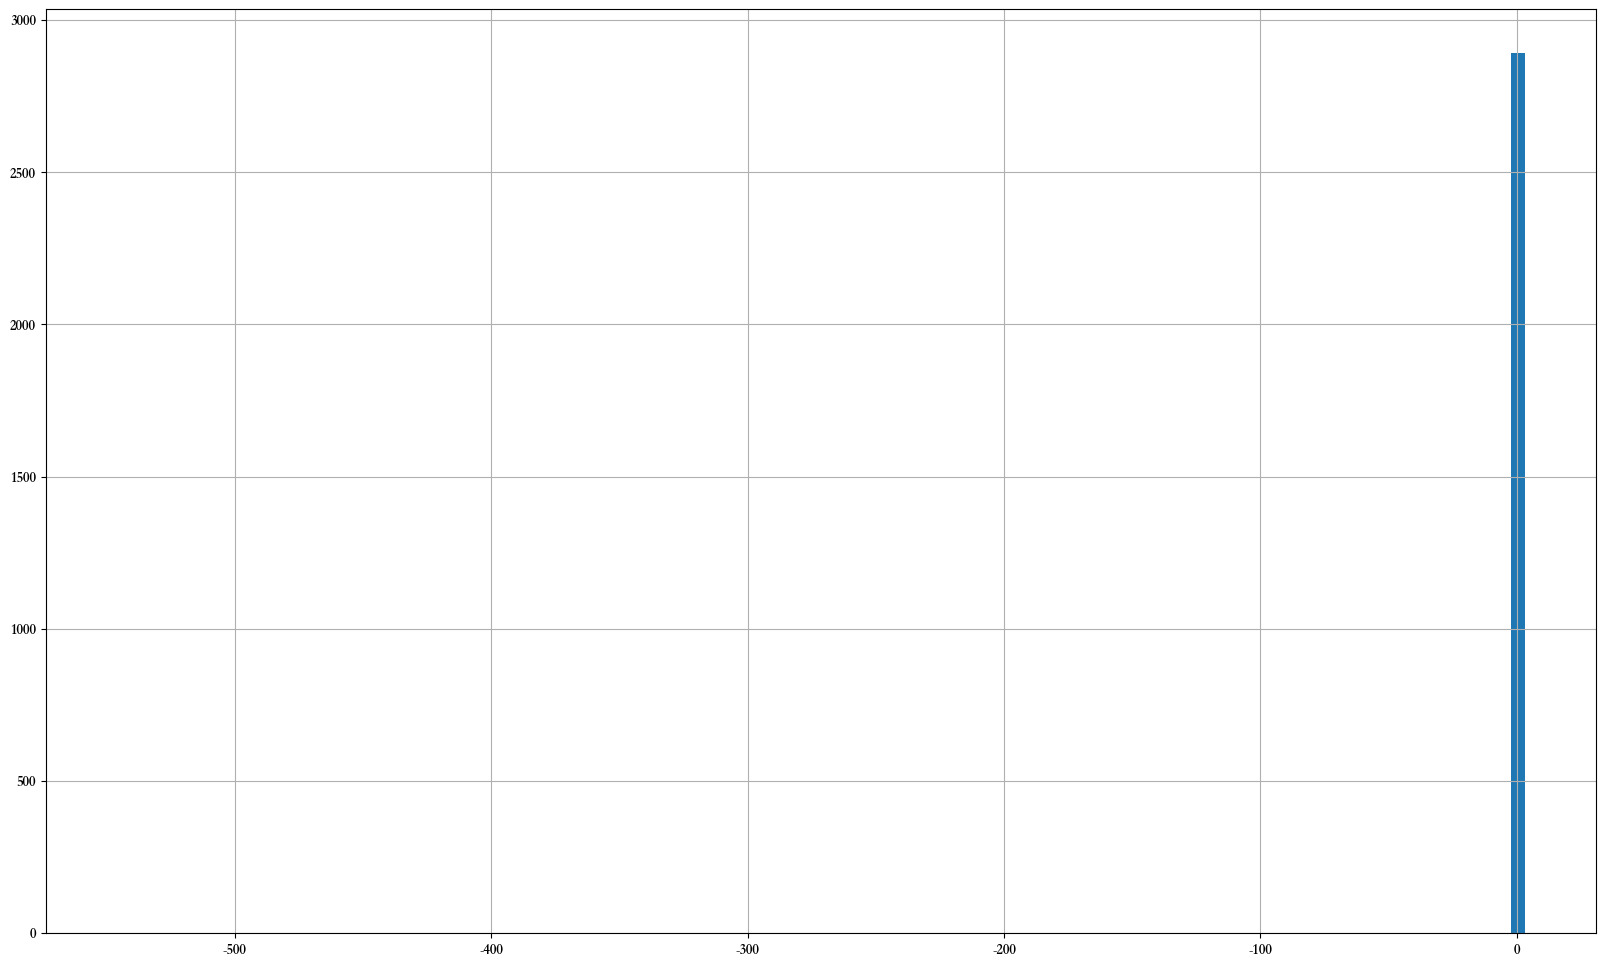

In [226]:
result.loc[:, '营业净利润率'].hist(figsize=(20, 12), bins=100)

可以看到营业净利润率差异非常大，我们来看一下营业净利润率小于-300%的股票。


In [227]:
# 归母净利润	营业收入	营业总支出	营业支出	销售支出	管理支出	财务支出	平均总资产	平均总负债	营业净利润率	总资产周转率	资产负债率	净资产	权益乘数	净资产收益率
selected_result = result.loc[result['营业净利润率']
                             <= -3, :].dropna(axis='columns', how='all')
indexer = (slice(None), [
           column for column in selected_result.columns if column not in ['股票简称']])
selected_result.style.format(
    "{:.3e}", indexer).highlight_min(color='green').highlight_max(color='red')

,股票简称,归母净利润,扣减归母净利润,营业总收入,营业收入,利息净收入,手续费及佣金净收入,已赚保费收入,投资收入,营业总支出,营业支出,销售支出,管理支出,财务支出,收入税支出,营业税金及附加费支出,退保金额支出,赔付支出,平均总资产,平均固定资产,平均货币资金,平均应收账款,平均总负债,平均应付账款,平均股东权益合计,营业净利润率,总资产周转率,资产负债率,净资产,权益乘数,净资产收益率
股票代码,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
688062,迈威生物,-2.778e+09,-2.799e+09,1.718e+08,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,2.988e+09,4.520e+06,2.427e+08,5.825e+08,-6.470e+07,3.524e+06,6.487e+06,0.000e+00,0.000e+00,3.047e+09,4.740e+08,9.780e+08,8.868e+06,1.025e+09,4.244e+07,2.022e+09,-1.617e+01,5.638e-02,3.364e-01,2.022e+09,1.507e+00,-1.374e+00
688176,亚虹医药,-8.819e+08,-9.375e+08,1.378e+07,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,1.009e+09,2.896e+06,5.252e+07,2.172e+08,-6.335e+07,8.097e+05,9.255e+05,0.000e+00,0.000e+00,1.738e+09,1.958e+07,1.009e+09,nan,1.398e+08,4.753e+07,1.598e+09,-6.398e+01,7.931e-03,8.046e-02,1.598e+09,1.088e+00,-5.519e-01
688221,前沿生物,-9.458e+08,-1.065e+09,2.395e+08,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,1.306e+09,2.029e+08,1.793e+08,2.520e+08,2.616e+06,0.000e+00,8.132e+06,0.000e+00,0.000e+00,2.328e+09,5.638e+07,6.829e+08,4.744e+07,5.866e+08,1.549e+07,1.742e+09,-3.949e+00,1.029e-01,2.519e-01,1.742e+09,1.337e+00,-5.430e-01
688302,海创药业,-9.019e+08,-1.011e+09,1.651e+06,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,1.013e+09,7.665e+05,8.359e+06,2.570e+08,-1.813e+07,1.909e+04,8.307e+05,0.000e+00,0.000e+00,1.340e+09,5.055e+06,9.759e+08,nan,1.631e+08,7.277e+07,1.177e+09,-5.463e+02,1.232e-03,1.217e-01,1.177e+09,1.139e+00,-7.665e-01
688373,盟科药业,-8.677e+08,-9.859e+08,1.466e+08,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,1.134e+09,2.610e+07,2.561e+08,1.830e+08,2.139e+07,6.016e+06,4.661e+05,0.000e+00,0.000e+00,9.188e+08,4.095e+06,1.964e+08,nan,1.916e+08,4.488e+07,7.271e+08,-5.917e+00,1.596e-01,2.086e-01,7.271e+08,1.264e+00,-1.193e+00


<Axes: >

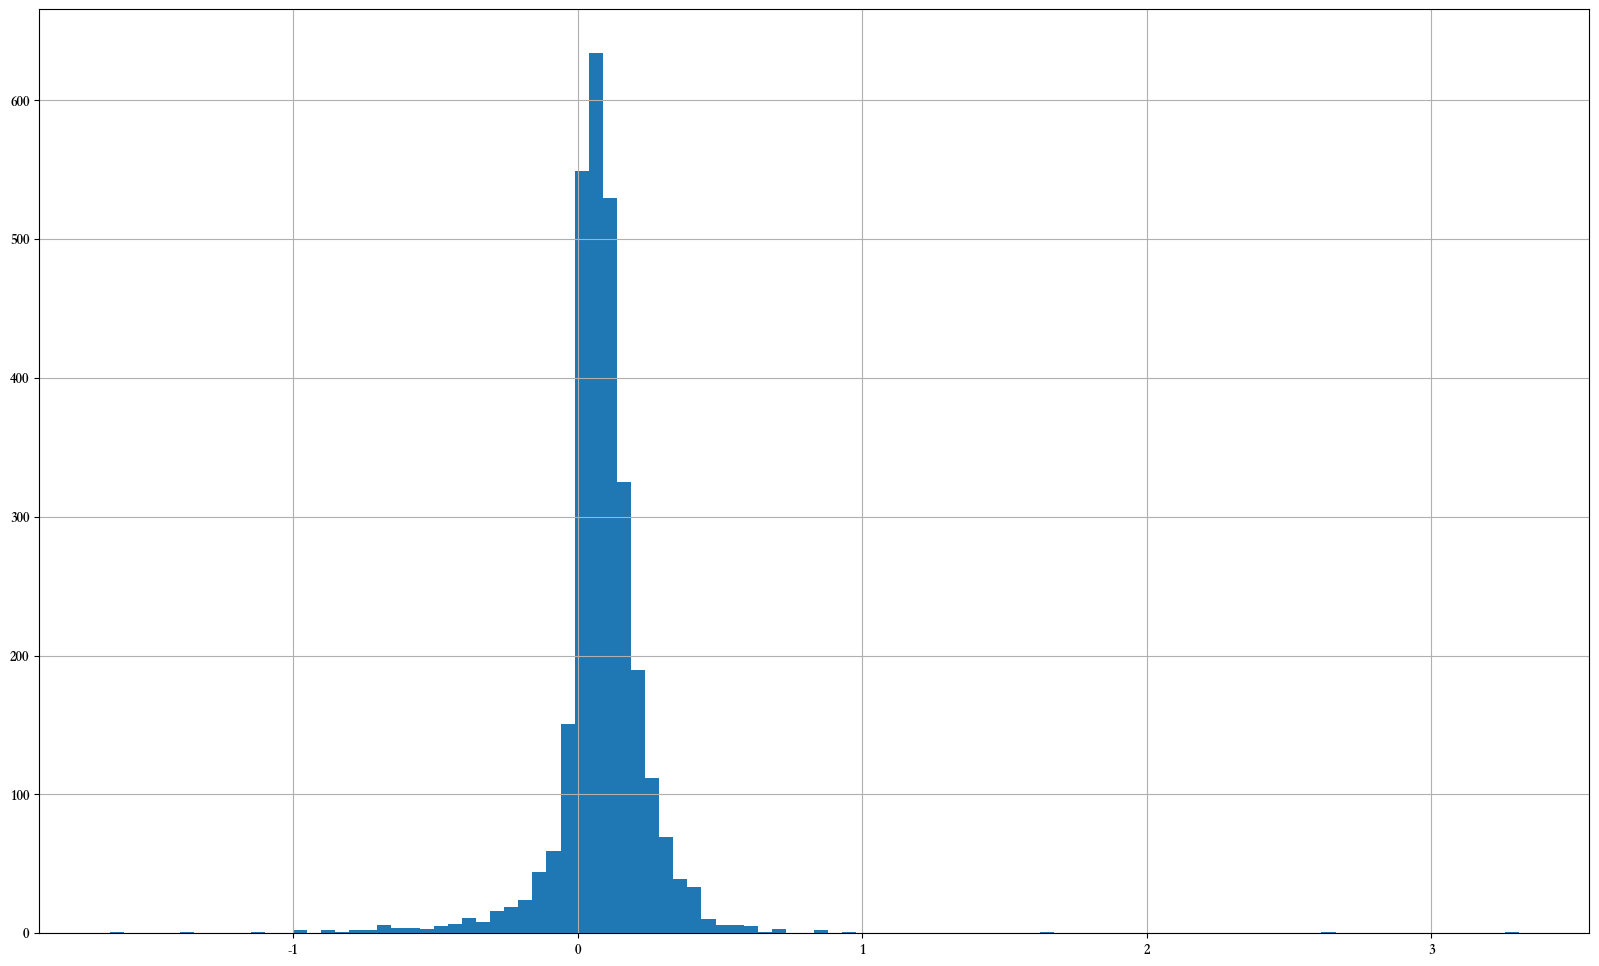

In [228]:
result.loc[result['营业净利润率'] > -3, '营业净利润率'].hist(figsize=(20, 12), bins=100)

- 查看总资产周转率的概况。


<Axes: >

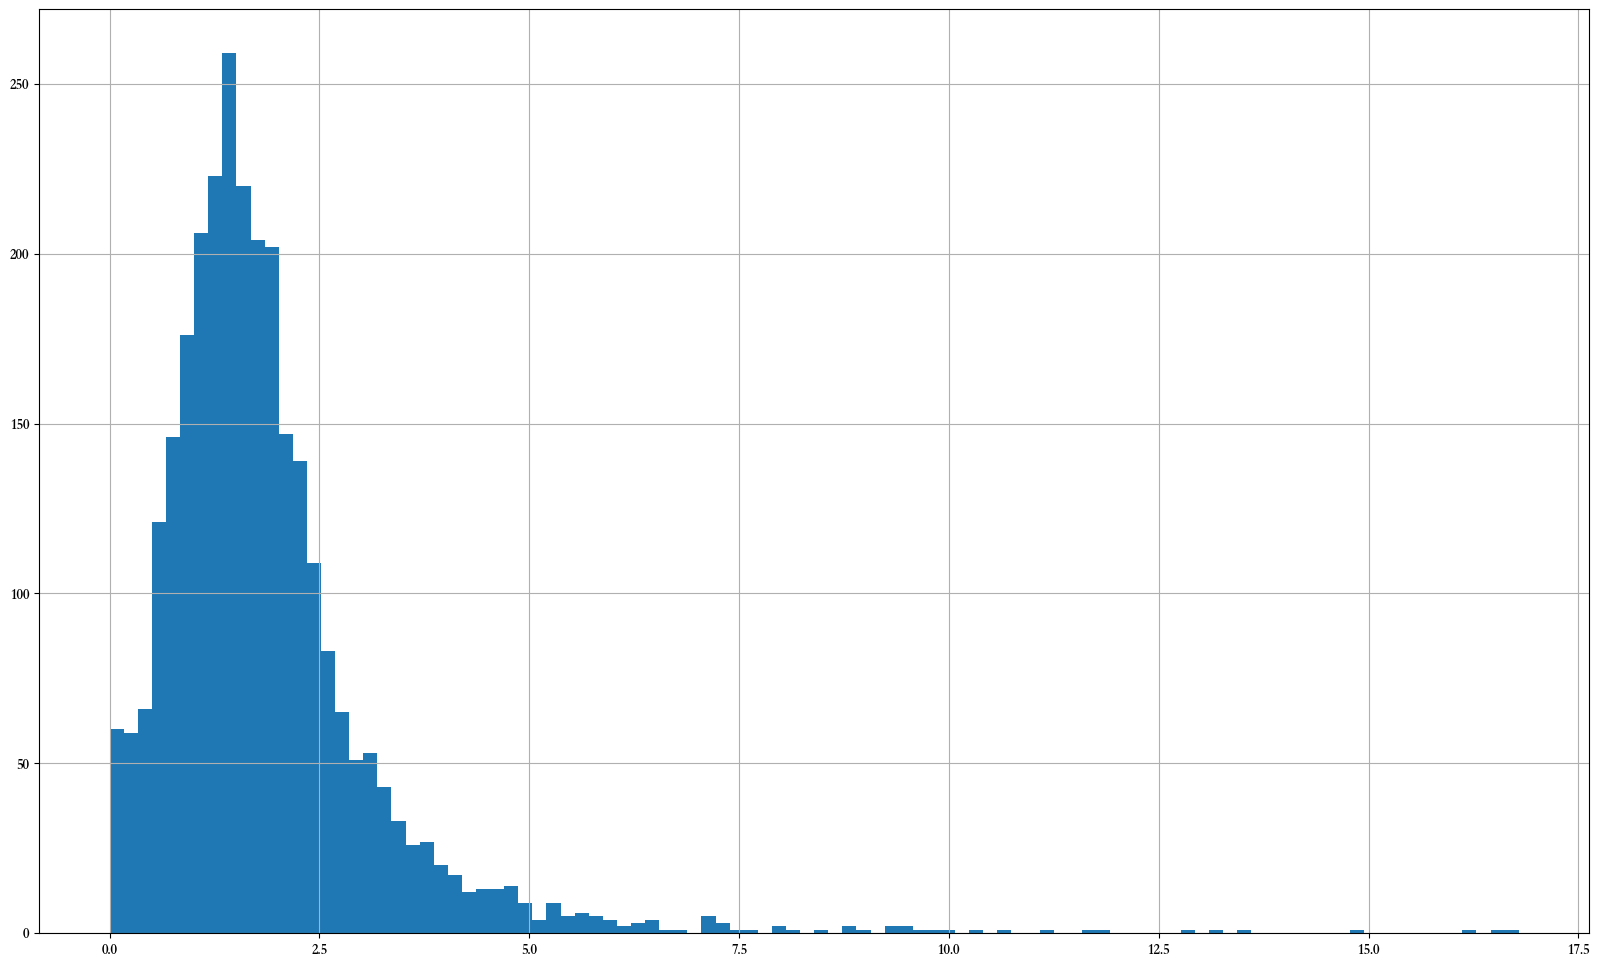

In [229]:
result.loc[:, '总资产周转率'].hist(figsize=(20, 12), bins=100)

- 查看权益乘数的概况。


<Axes: >

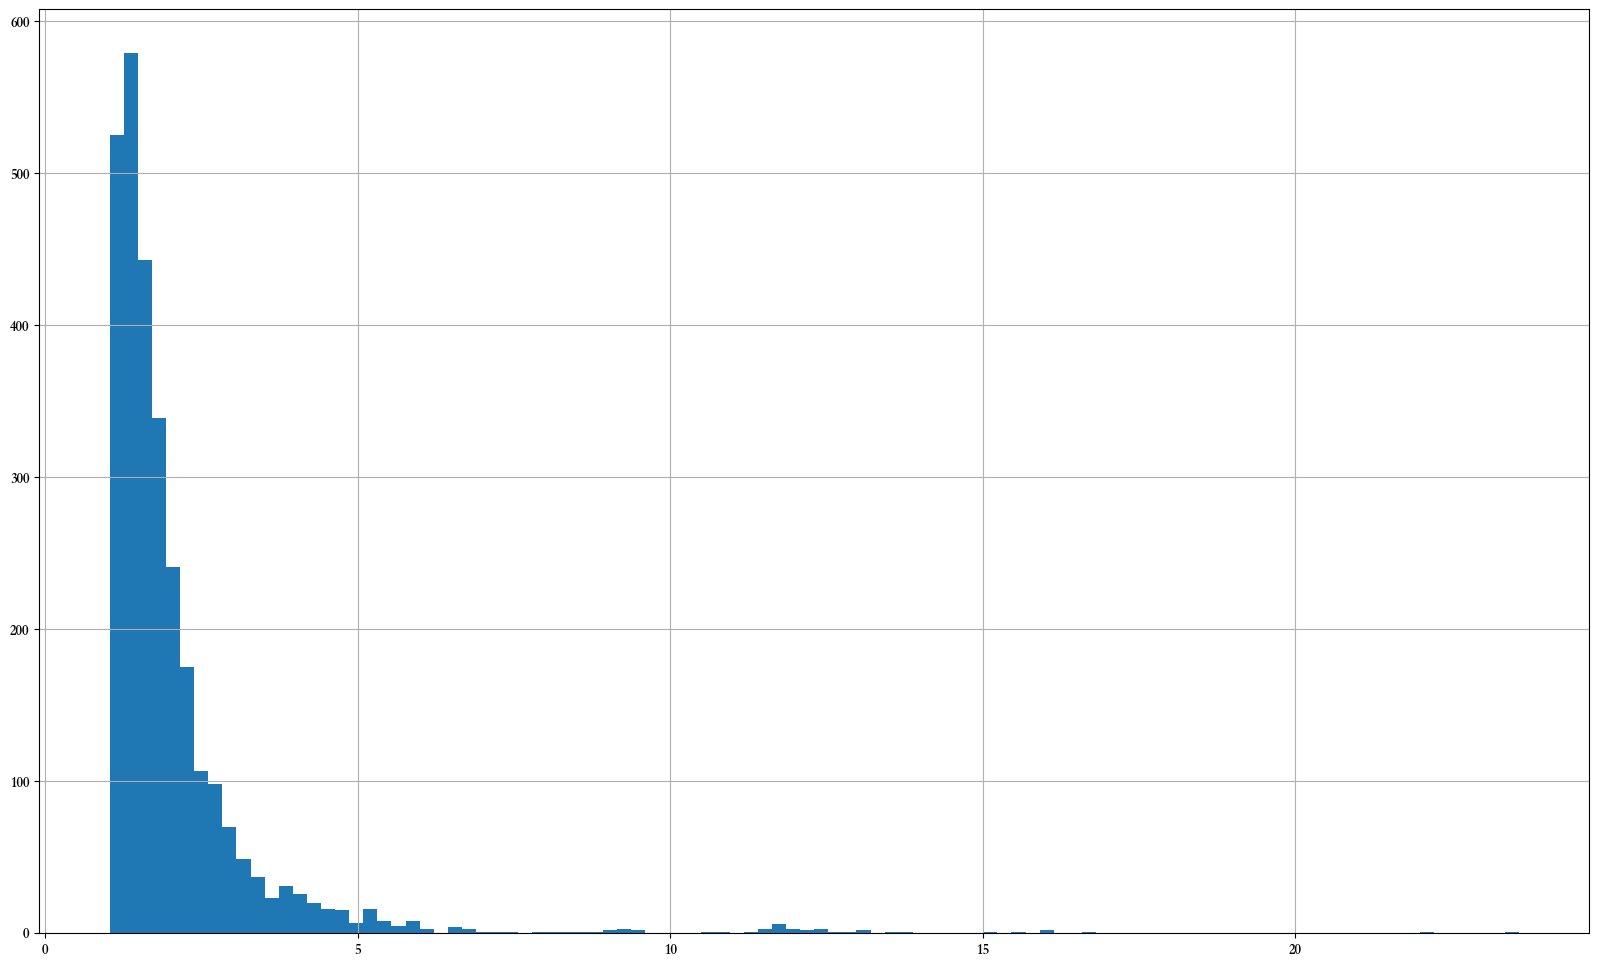

In [230]:
result.loc[:, '权益乘数'].hist(figsize=(20, 12), bins=100)

- 查看 ROE 的概况。


<Axes: >

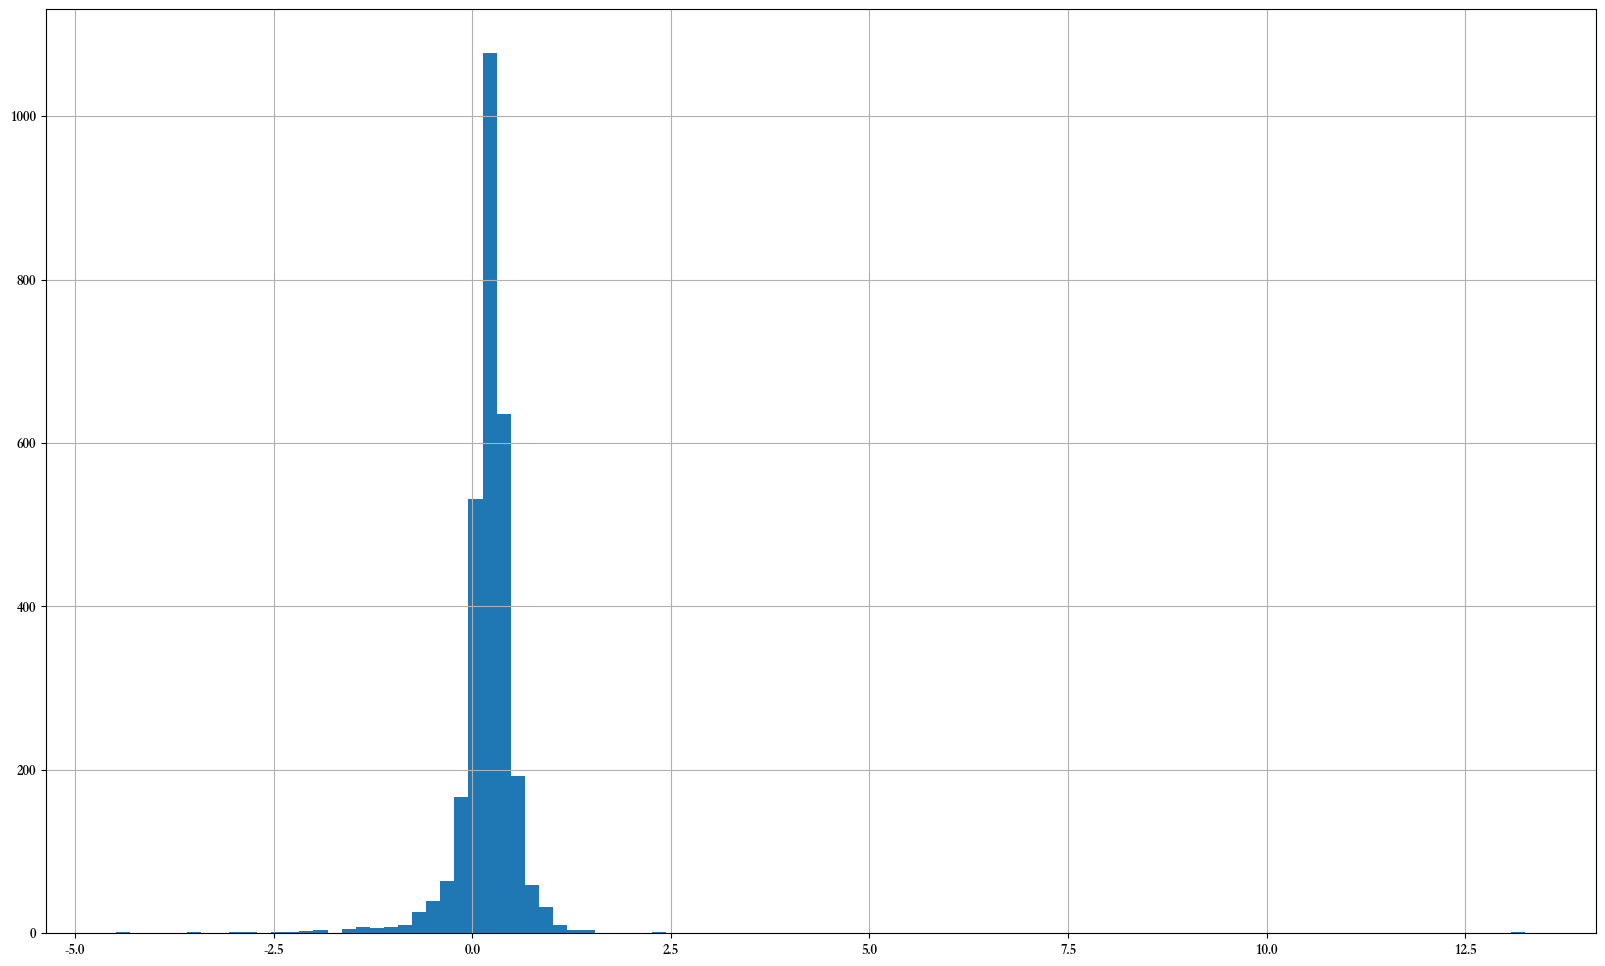

In [231]:
result.loc[:, '净资产收益率'].hist(figsize=(20, 12), bins=100)

In [232]:
best = result.loc[:, '净资产收益率'].sort_values(ascending=False).head(10)
best

股票代码
002188    13.255683
600078     2.295685
002192     1.476256
600132     1.442816
000792     1.399546
601919     1.384907
603688     1.339847
002030     1.336362
300122     1.298834
688303     1.260938
Name: 净资产收益率, dtype: float64

### 板块分析

#### 概念板块分析


In [233]:
def cache(p: pl.Path, getter: Callable[[], pd.DataFrame]) -> pd.DataFrame:
    if not path.exists(p):
        df = getter()
        df.to_pickle(p)
    return pd.read_pickle(p)


def process_board(name: str, board: pd.DataFrame) -> pd.DataFrame:
    concept_boards_available = set(
        board.loc[:, '代码']).intersection(codes_real)
    concept_boards_available_list = [*concept_boards_available]
    # print(name, concept_boards_available)
    res = pd.DataFrame.from_dict({
        '股票代码': concept_boards_available_list,
        '净资产收益率': result.loc[concept_boards_available_list, '净资产收益率'],
    })
    res.set_index('股票代码', inplace=True)
    return res


# 可用的股票代码
codes_real = list(result.index.array)


def process_boards(name: str, chinese: str, get_list: Callable[[], pd.DataFrame], getter: Callable[[str], pd.DataFrame]):
    DIR = pl.Path(f'data/{name}')
    os.makedirs(DIR, exist_ok=True)
    board_list = cache(
        pl.Path(f"data/{name}.pkl"), get_list)
    boards = {
        name: cache(pl.Path(DIR / f"{name.replace('/', ',')}.pkl"), lambda: getter(name)) for name in board_list['板块名称']
    }
    print(f"共计 {len(boards)} 个{chinese}。")

    boards_res = [(name, process_board(name, board))
                  for name, board in boards.items()]
    boards_res.sort(
        key=lambda x: x[1].shape[0], reverse=True)
    for name, board in boards_res[:10]:
        board.hist(bins=50, legend=True)
        plt.title(name+f"（共计 {board.shape[0]} 支股票）")

共计 455 个概念板块。


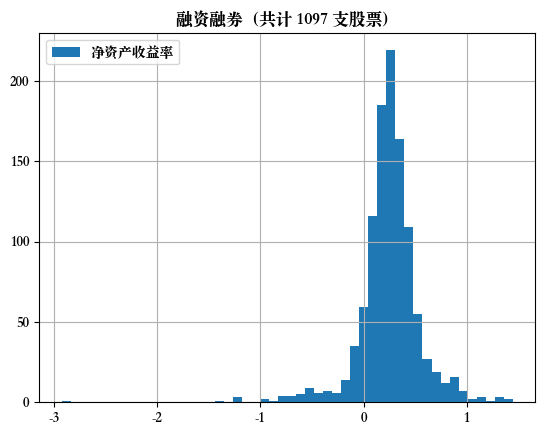

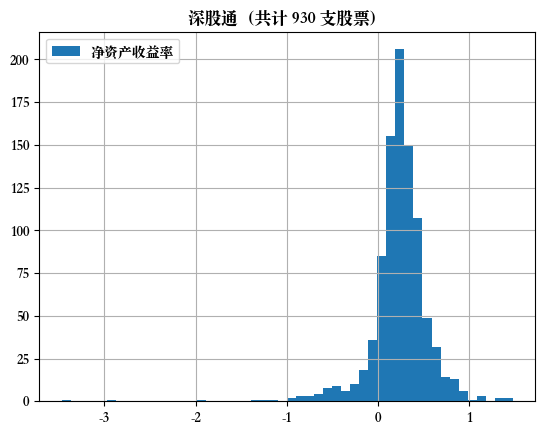

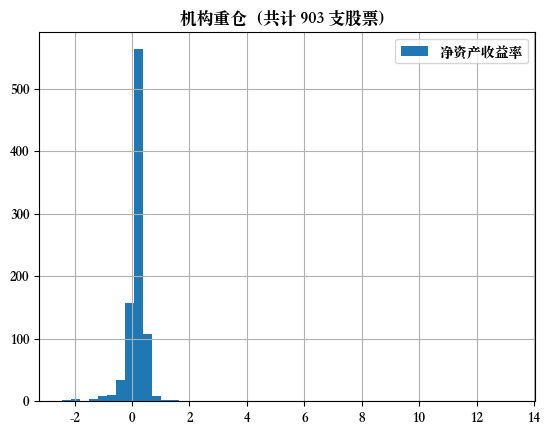

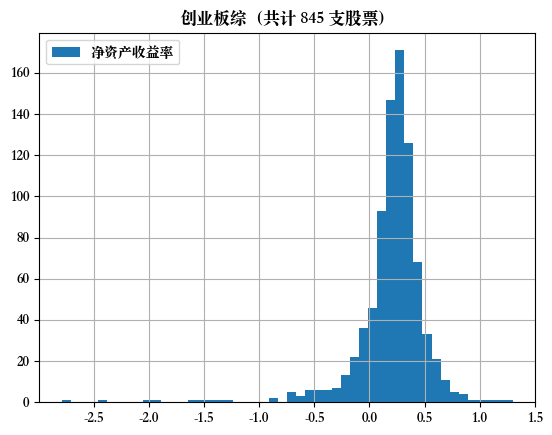

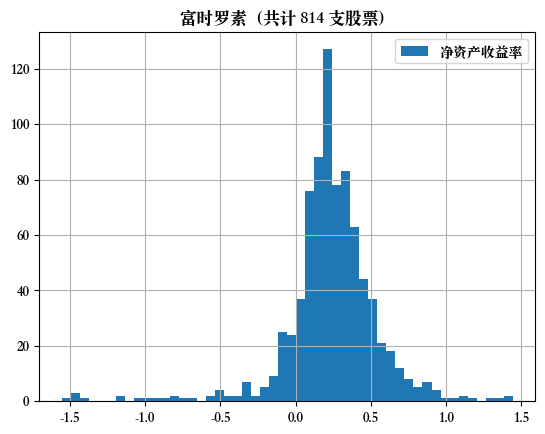

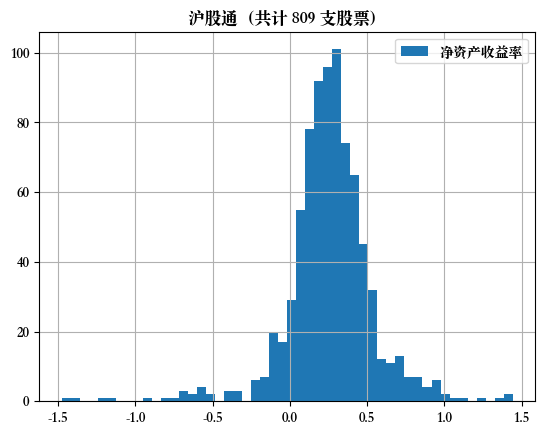

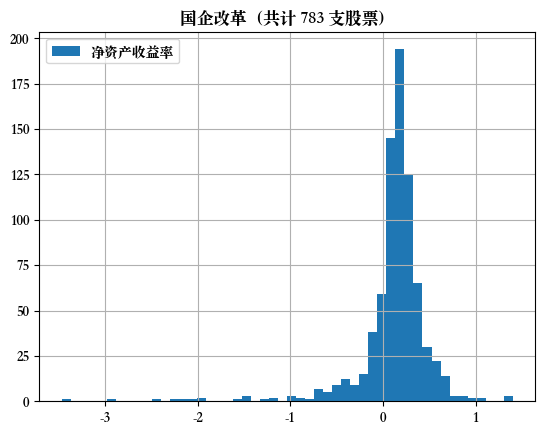

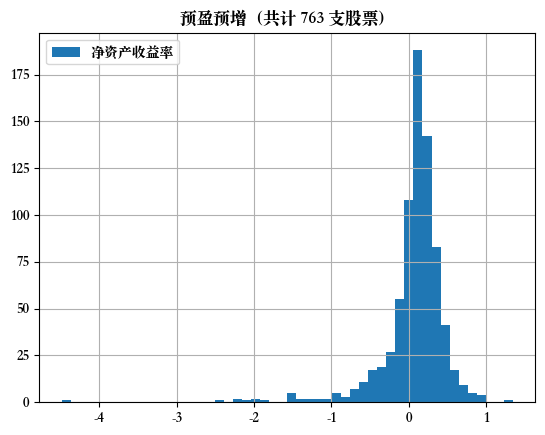

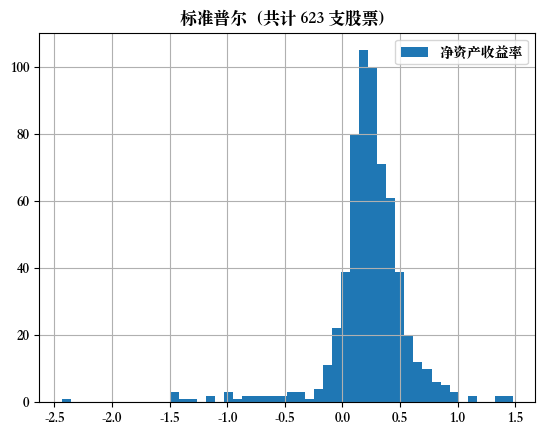

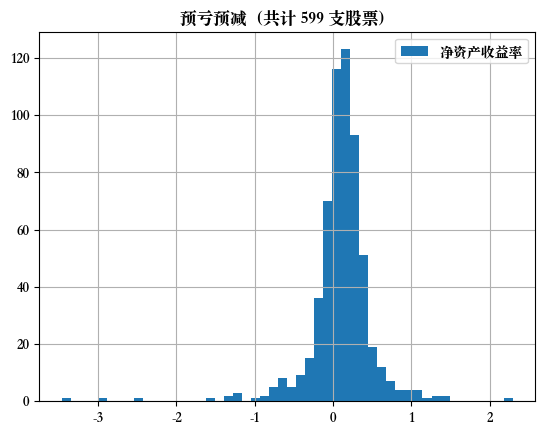

In [234]:
process_boards("concept_board", "概念板块",
               ak.stock_board_concept_name_em, ak.stock_board_concept_cons_em)

#### 行业板块分析


共计 86 个行业板块。


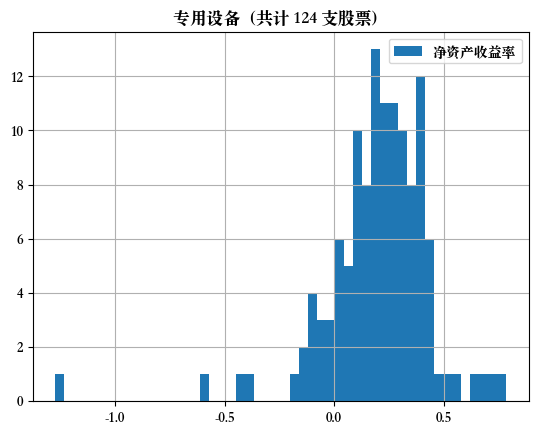

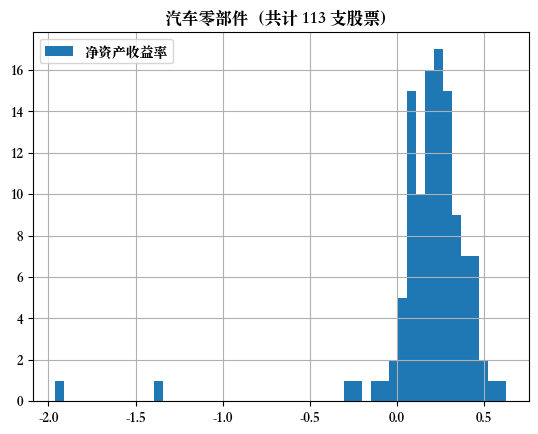

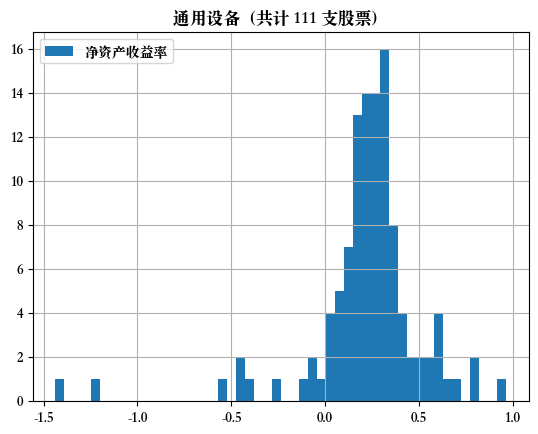

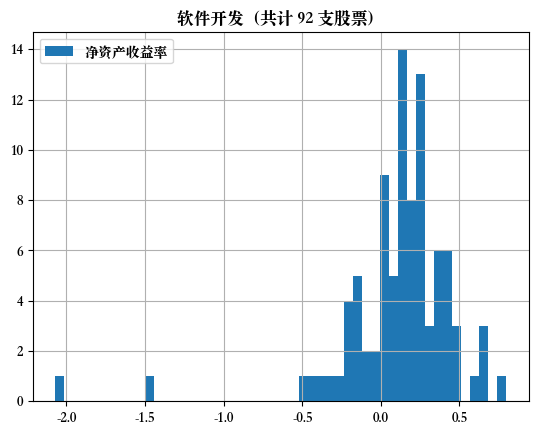

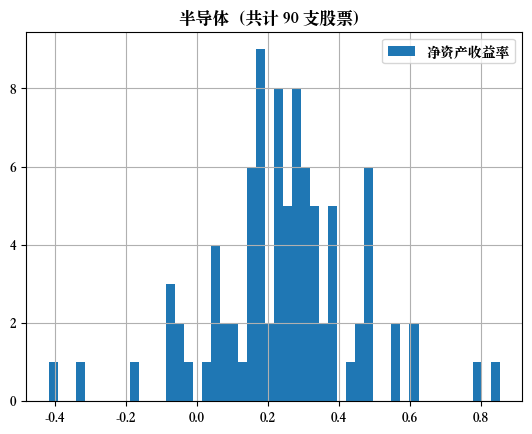

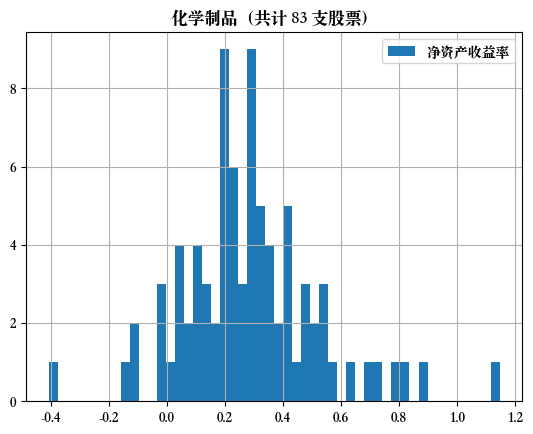

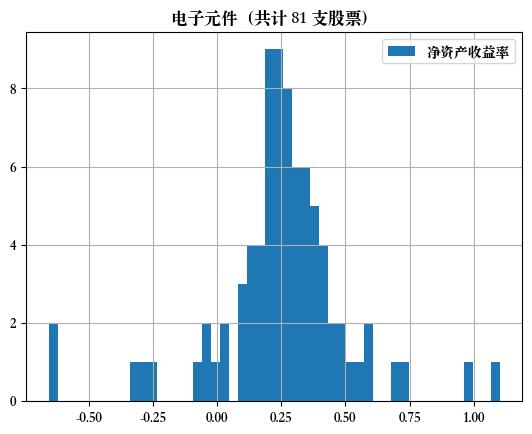

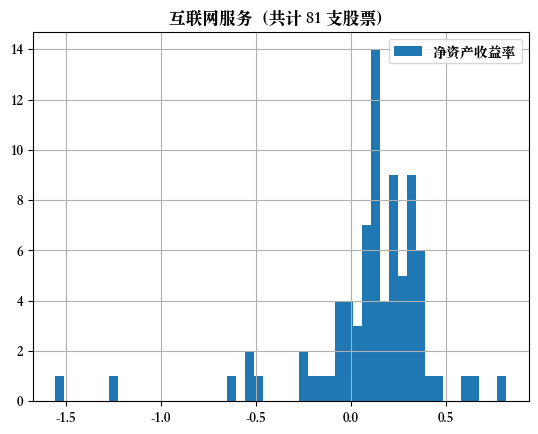

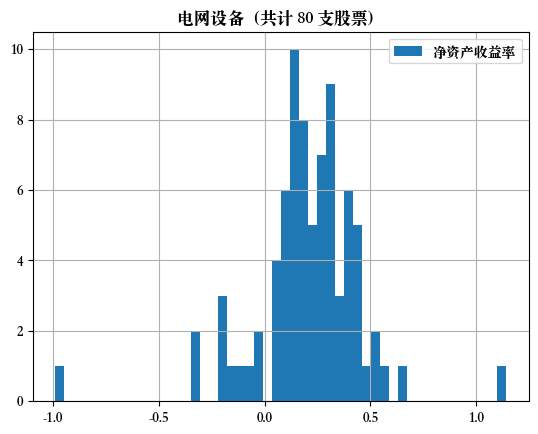

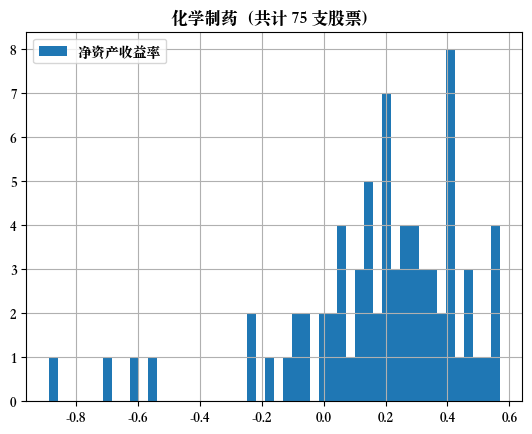

In [235]:
process_boards("industry_board", "行业板块",
               ak.stock_board_industry_name_em, ak.stock_board_industry_cons_em)

### 杜邦分析

参见[杜邦分析设置](#杜邦分析设置)。


In [236]:
for code in best.index.array:
    x = result.loc[code]
    name = result.loc[code, '股票简称']
    s = f"""
## {name}

```mermaid
classDiagram
净资产收益率 -- 总资产净利率
    净资产收益率 : {x.loc['净资产收益率'] * 100:.2f}%
    净资产收益率 : ROE(净利润 /  股东权益)
    总资产净利率 : {x.loc['营业净利润率'] * x.loc['总资产周转率'] * 100:.2f}% = （营业净利润率 X 总资产周转率）
    总资产净利率 : ProfitMagin(净利润 /  营业收入)
净资产收益率 -- 权益乘数
    权益乘数 : {x.loc['权益乘数']:.2f} = 1 ➗ （1 - 资产负债率）
    权益乘数 : EquityMultiplier(总资产 /  股东权益)
    
总资产净利率 -- 营业净利润率
    营业净利润率 : {x.loc['营业净利润率'] * 100:.2f}% = （净利润 ➗ 营业总收入）
总资产净利率 -- 总资产周转率
    总资产周转率 : {x.loc['总资产周转率']:.3f}次 =（营业总收入 ➗ 资产总额）
权益乘数 -- 资产负债率
    资产负债率  : {x.loc['资产负债率']*100:.2f}% =（负债总额 ➗ 资产总额）
    资产负债率  : ratio(负债总额 / 资产总额)

营业净利润率 -- 净利润
    净利润 : {x.loc['归母净利润']/1e8:.2f}亿 = 收入总额 - 成本总额
营业净利润率 -- 营业总收入
    营业总收入 : {x.loc['营业总收入']/1e8:.2f}亿
总资产周转率 -- 营业总收入
总资产周转率 -- 资产总额
    资产总额 : {x.loc['平均总资产']/1e8:.2f}亿 = 流动资产 + 非流动资产
资产负债率 -- 　负债总额
    负债总额 : {x.loc['平均总负债']/1e8:.2f}亿
资产负债率 -- 　资产总额


净利润 -- 收入总额
    收入总额 : {x.loc['营业收入']/1e8:.2f}亿
净利润 -- 成本总额
    成本总额 : {x.loc['营业总支出']/1e8:.2f}亿

收入总额 -- 包括1
    包括1 : 营业收入
    包括1 : {x.loc['营业收入']/1e8:.2f}亿
    包括1 : 利息净收入
    包括1 : {x.loc['利息净收入']/1e8:.2f}亿
    包括1 : 手续费及佣金净收入
    包括1 : {x.loc['手续费及佣金净收入']/1e8:.2f}亿
    包括1 : 已赚保费收入
    包括1 : {x.loc['已赚保费收入']/1e8:.2f}亿
    包括1 : 投资收入
    包括1 : {x.loc['投资收入']/1e8:.2f}亿
    包括1 : ...
成本总额 -- 包括2
    包括2 : 营业成本
    包括2 : {x.loc['营业支出']/1e8:.2f}亿
    包括2 : 销售支出
    包括2 : {x.loc['销售支出']/1e8:.2f}亿
    包括2 : 管理支出
    包括2 : {x.loc['管理支出']/1e8:.2f}亿
    包括2 : 财务支出
    包括2 : {x.loc['财务支出']/1e8:.2f}亿
    包括2 : 收入税支出
    包括2 : {x.loc['收入税支出']/1e8:.2f}亿
    包括2 : 营业税金及附加费支出
    包括2 : {x.loc['营业税金及附加费支出']/1e8:.2f}亿
    包括2 : 退保金额支出
    包括2 : {x.loc['退保金额支出']/1e8:.2f}亿
    包括2 : 赔付支出
    包括2 : {x.loc['赔付支出']/1e8:.2f}亿
    包括2 : ...
流动资产 -- 包括4
    包括4 : 货币资金
    包括4 : {x.loc['平均货币资金']/1e8:.2f}亿
    包括4 : 交易性金融资产
    包括4 : {x.loc['平均可供出售金融资产']/1e8:.2f}亿
    包括4 : 应收票据
    包括4 : 27.81万
    包括4 : 应收账款
    包括4 : 196.0亿
    包括4 : 应收款项融资
    包括4 : --
    包括4 : 其他应收款
    包括4 : 3.272亿
    包括4 : 存货
    包括4 : 5.877亿
非流动资产 -- 包括5_1
    包括5_1 : 债券投资
    包括5_1 : 9.754亿
    包括5_1 : 其他债权投资
    包括5_1 : --
    包括5_1 : 其他权益工具投资
    包括5_1 : 33.62亿
    包括5_1 : 长期应收款
    包括5_1 : --
    包括5_1 : 长期股权投资
    包括5_1 : 679.5亿
    包括5_1 : 投资性房地产
    包括5_1 : 9666万
    包括5_1 : 固定资产
    包括5_1 : 4457亿
    包括5_1 : 在建工程
    包括5_1 : 39.88亿
    包括5_1 : ...
非流动资产 -- 包括5_2
    包括5_2 : 使用权资产
    包括5_2 : 6.342亿
    包括5_2 : 无形资产
    包括5_2 : 219.1亿
    包括5_2 : 开发支出
    包括5_2 : 9077万
    包括5_2 : 商誉
    包括5_2 : 10.67亿
    包括5_2 : 长期待摊费用
    包括5_2 : 5553万
    包括5_2 : 递延所得税资产
    包括5_2 : 4.208亿
    包括5_2 : 可供出售金融资产
    包括5_2 : --
    包括5_2 : 持有至到期投资
    包括5_2 : --
```
"""
    print(s)


## 中天服务

```mermaid
classDiagram
净资产收益率 -- 总资产净利率
    净资产收益率 : 1325.57%
    净资产收益率 : ROE(净利润 /  股东权益)
    总资产净利率 : 95.96% = （营业净利润率 X 总资产周转率）
    总资产净利率 : ProfitMagin(净利润 /  营业收入)
净资产收益率 -- 权益乘数
    权益乘数 : 13.81 = 1 ➗ （1 - 资产负债率）
    权益乘数 : EquityMultiplier(总资产 /  股东权益)
    
总资产净利率 -- 营业净利润率
    营业净利润率 : 25.13% = （净利润 ➗ 营业总收入）
总资产净利率 -- 总资产周转率
    总资产周转率 : 3.818次 =（营业总收入 ➗ 资产总额）
权益乘数 -- 资产负债率
    资产负债率  : 92.76% =（负债总额 ➗ 资产总额）
    资产负债率  : ratio(负债总额 / 资产总额)

营业净利润率 -- 净利润
    净利润 : 2.31亿 = 收入总额 - 成本总额
营业净利润率 -- 营业总收入
    营业总收入 : 9.20亿
总资产周转率 -- 营业总收入
总资产周转率 -- 资产总额
    资产总额 : 2.41亿 = 流动资产 + 非流动资产
资产负债率 -- 　负债总额
    负债总额 : 2.24亿
资产负债率 -- 　资产总额


净利润 -- 收入总额
    收入总额 : 0.00亿
净利润 -- 成本总额
    成本总额 : 7.84亿

收入总额 -- 包括1
    包括1 : 营业收入
    包括1 : 0.00亿
    包括1 : 利息净收入
    包括1 : 0.00亿
    包括1 : 手续费及佣金净收入
    包括1 : 0.00亿
    包括1 : 已赚保费收入
    包括1 : 0.00亿
    包括1 : 投资收入
    包括1 : 0.00亿
    包括1 : ...
成本总额 -- 包括2
    包括2 : 营业成本
    包括2 : 6.42亿
    包括2 : 销售支出
    包括2 : 0.04亿
    包括2 : 管理支出
    包括2 

## 实验总结与自评分

此次作业计算了不同股票的 ROE，对各个板块内的公司进行了 ROE 的横向比较，并对 2021 年到 2023 年内 ROE 最高的公司进行了杜邦分析。

通过这次作业，我对 ROE 的计算方法有了更深入的了解，也学会了如何使用 akshare 库获取财务数据。

在以后的学习中，我会继续深入学习财务分析的知识，提高自己的分析能力。

自评分：

- Present：2 / 4 分，迟交。
- 源程序代码：4 / 4 分。注释较合适，代码较为整齐。
- 作业报告：4 / 4 分。几部分完整，但是深度有待提高。


## 感谢和收获

这次作业的，感谢老师。
